In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_20_41_15
NN-MODEL FILENAME:  ./models/VBKG0BIX_20_41_15_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 1000   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 20000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1284.40 MiB, increment: 1064.34 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


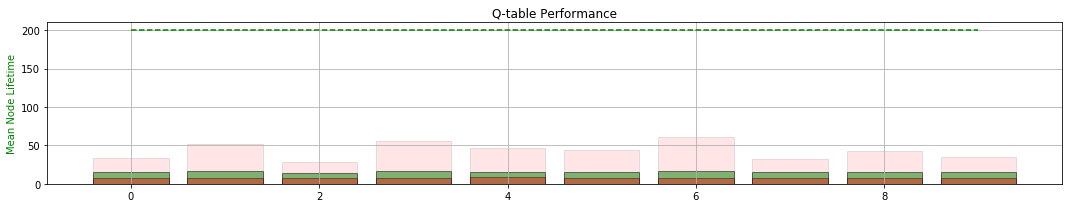

MEMORY COUNTER:  15558
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 599.236	LOSS : 601.146	LOSS : 583.291	LOSS : 565.479	
Validating... MEAN TIME:  25.97
LOSS : 540.695	LOSS : 557.044	LOSS : 542.380	LOSS : 523.637	
Validating... MEAN TIME:  9.435
LOSS : 522.689	LOSS : 507.423	LOSS : 516.254	LOSS : 508.476	
Validating... MEAN TIME:  9.29
LOSS : 519.106	LOSS : 525.226	LOSS : 515.805	LOSS : 514.931	
Validating... MEAN TIME:  9.375
LOSS : 522.019	LOSS : 517.660	LOSS : 515.673	LOSS : 513.936	
Validating... MEAN TIME:  9.3
TRAINING TIME:0:00:27.194190


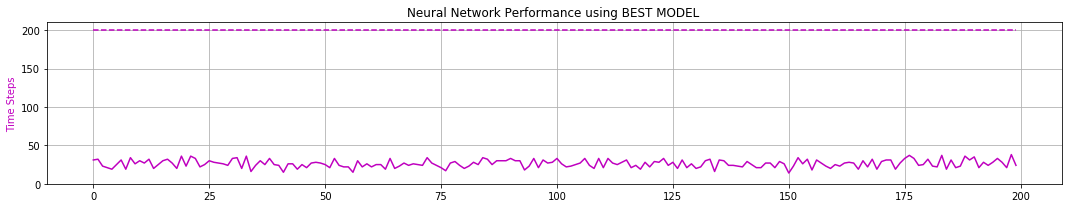

peak memory: 1330.62 MiB, increment: 1044.39 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   20585
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 99
TOTAL SERIAL TIMESTEPS:   36143
TOTAL PARALLEL TIMEST

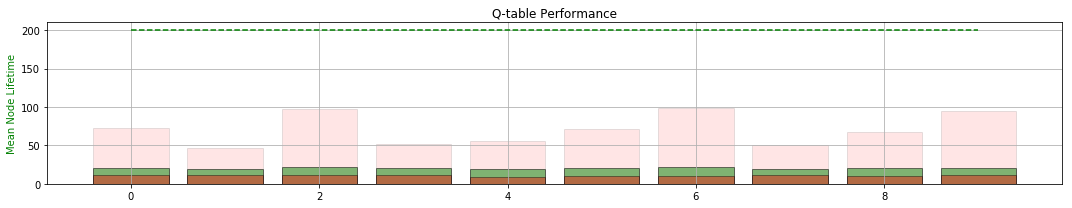

MEMORY COUNTER:  36143
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 481.513	LOSS : 476.711	LOSS : 484.451	LOSS : 499.026	
Validating... MEAN TIME:  14.855
LOSS : 475.459	LOSS : 469.092	LOSS : 465.295	LOSS : 470.779	
Validating... MEAN TIME:  90.305
LOSS : 464.221	LOSS : 476.729	LOSS : 459.673	LOSS : 482.069	
Validating... MEAN TIME:  85.22
LOSS : 478.648	LOSS : 459.792	LOSS : 447.982	LOSS : 473.300	
Validating... MEAN TIME:  67.295
LOSS : 467.165	LOSS : 476.613	LOSS : 467.680	LOSS : 464.700	
Validating... MEAN TIME:  74.94
TRAINING TIME:0:00:37.581627


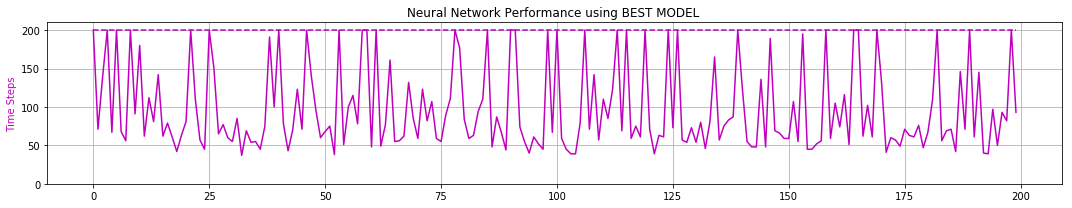

peak memory: 1380.14 MiB, increment: 1037.18 MiB
0 -max- [ 0.063  0.629  0.209  1.758]
0 -min- [-0.469 -1.176 -0.082 -0.896]

1 -max- [ 0.066  0.609  0.209  1.891]
1 -min- [-0.271 -1.197 -0.208 -1.044]

2 -max- [ 0.085  0.627  0.209  2.138]
2 -min- [-1.484 -2.605 -0.208 -0.961]

3 -max- [ 0.079  0.427  0.209  1.938]
3 -min- [-0.312 -1.141 -0.209 -0.754]

4 -max- [ 0.054  0.629  0.209  2.022]
4 -min- [-0.302 -1.220 -0.094 -0.946]

5 -max- [ 0.124  0.823  0.209  1.959]
5 -min- [-0.427 -1.208 -0.120 -1.204]

6 -max- [ 0.054  0.582  0.209  2.096]
6 -min- [-0.555 -1.225 -0.191 -1.166]

7 -max- [ 0.061  0.404  0.209  1.718]
7 -min- [-0.274 -1.008 -0.061 -0.634]

8 -max- [ 0.094  0.739  0.209  2.003]
8 -min- [-0.582 -1.326 -0.201 -1.274]

9 -max- [ 0.052  0.621  0.209  2.142]
9 -min- [-0.634 -1.364 -0.207 -0.906]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   48276
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 147
TOTAL SERIAL TIMESTEPS:   84419
TOTAL PARALLEL TIME

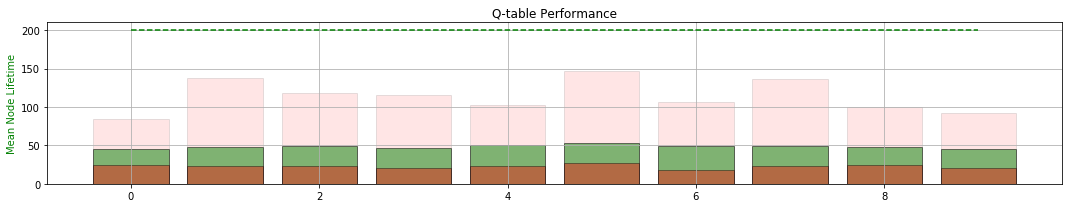

MEMORY COUNTER:  84419
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 315.788	LOSS : 323.910	LOSS : 322.395	LOSS : 328.325	
Validating... MEAN TIME:  68.29
LOSS : 331.835	LOSS : 305.733	LOSS : 305.633	LOSS : 324.599	
Validating... MEAN TIME:  75.085
LOSS : 333.605	LOSS : 321.771	LOSS : 304.616	LOSS : 321.249	
Validating... MEAN TIME:  83.055
LOSS : 310.429	LOSS : 316.931	LOSS : 318.236	LOSS : 307.270	
Validating... MEAN TIME:  92.68
LOSS : 322.222	LOSS : 317.890	LOSS : 304.966	LOSS : 307.587	
Validating... MEAN TIME:  103.885
TRAINING TIME:0:00:42.104831


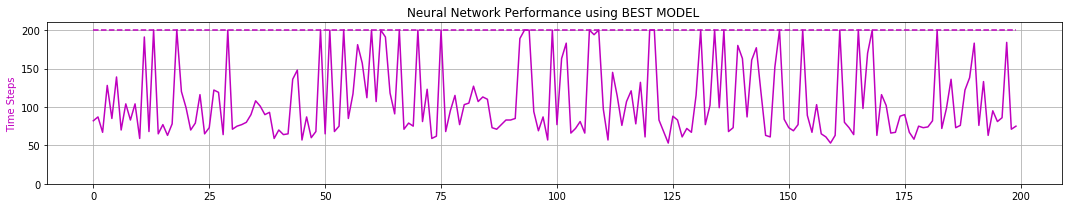

peak memory: 1403.91 MiB, increment: 1018.27 MiB
0 -max- [ 0.140  0.762  0.209  1.440]
0 -min- [-0.390 -0.932 -0.209 -1.144]

1 -max- [ 0.117  0.939  0.209  1.612]
1 -min- [-0.480 -0.992 -0.208 -1.050]

2 -max- [ 0.214  0.941  0.209  1.642]
2 -min- [-0.395 -0.942 -0.208 -1.387]

3 -max- [ 0.191  0.958  0.209  1.266]
3 -min- [-0.372 -0.912 -0.209 -1.062]

4 -max- [ 0.147  0.949  0.209  1.419]
4 -min- [-0.544 -1.168 -0.208 -1.400]

5 -max- [ 0.115  0.902  0.209  1.383]
5 -min- [-0.490 -0.974 -0.208 -1.050]

6 -max- [ 0.150  0.869  0.209  1.566]
6 -min- [-0.425 -0.944 -0.208 -1.159]

7 -max- [ 0.136  0.762  0.209  1.469]
7 -min- [-0.378 -0.944 -0.209 -1.107]

8 -max- [ 0.136  0.758  0.209  1.445]
8 -min- [-0.371 -0.974 -0.207 -1.052]

9 -max- [ 0.107  0.749  0.209  1.383]
9 -min- [-0.427 -1.087 -0.207 -1.286]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   65299
SMALLEST TIMESTEP: 39
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   149718
TOTAL PARALLEL TIM

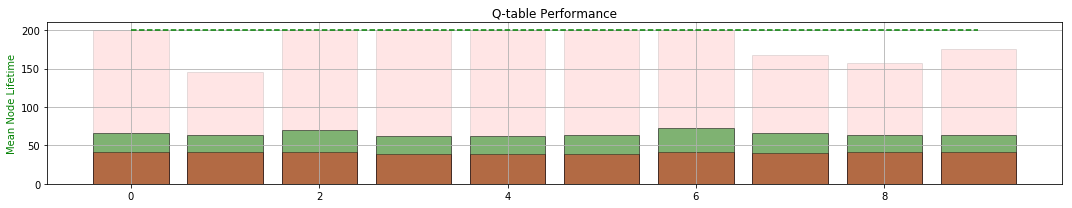

MEMORY COUNTER:  149718
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 242.243	LOSS : 239.451	LOSS : 246.299	LOSS : 246.813	
Validating... MEAN TIME:  118.09
LOSS : 245.483	LOSS : 244.623	LOSS : 242.703	LOSS : 254.308	
Validating... MEAN TIME:  115.49
LOSS : 249.175	LOSS : 250.225	LOSS : 237.913	LOSS : 250.808	
Validating... MEAN TIME:  117.675
LOSS : 228.413	LOSS : 243.762	LOSS : 256.696	LOSS : 243.097	
Validating... MEAN TIME:  117.035
LOSS : 252.815	LOSS : 243.416	LOSS : 255.549	LOSS : 234.694	
Validating... MEAN TIME:  122.68
TRAINING TIME:0:00:47.966129


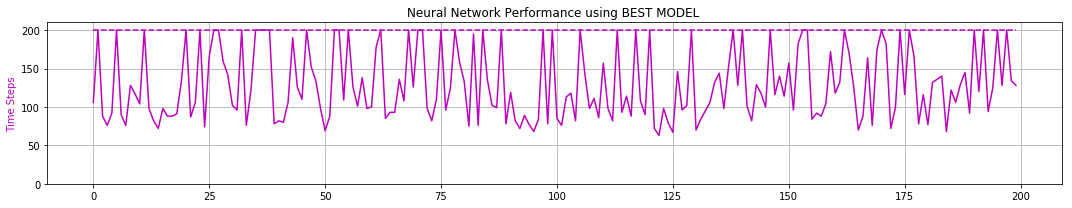

peak memory: 1407.62 MiB, increment: 1018.16 MiB
0 -max- [ 0.438  0.935  0.209  1.082]
0 -min- [-0.276 -1.124 -0.209 -0.973]

1 -max- [ 0.421  0.859  0.209  0.797]
1 -min- [-0.289 -1.140 -0.209 -0.819]

2 -max- [ 0.475  0.865  0.209  1.050]
2 -min- [-0.271 -1.091 -0.209 -1.005]

3 -max- [ 0.426  0.781  0.208  0.800]
3 -min- [-0.285 -1.103 -0.209 -0.799]

4 -max- [ 0.429  0.952  0.209  1.003]
4 -min- [-0.277 -1.083 -0.209 -1.133]

5 -max- [ 0.421  0.773  0.209  0.799]
5 -min- [-0.271 -1.097 -0.209 -0.797]

6 -max- [ 0.444  0.780  0.209  0.832]
6 -min- [-0.285 -1.146 -0.209 -1.069]

7 -max- [ 0.441  0.885  0.209  0.788]
7 -min- [-0.288 -1.094 -0.209 -0.800]

8 -max- [ 0.435  0.887  0.207  0.788]
8 -min- [-0.300 -1.086 -0.209 -0.794]

9 -max- [ 0.438  0.900  0.209  1.004]
9 -min- [-0.277 -1.113 -0.209 -0.828]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   76111
SMALLEST TIMESTEP: 39
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   225829
TOTAL PARALLEL TIM

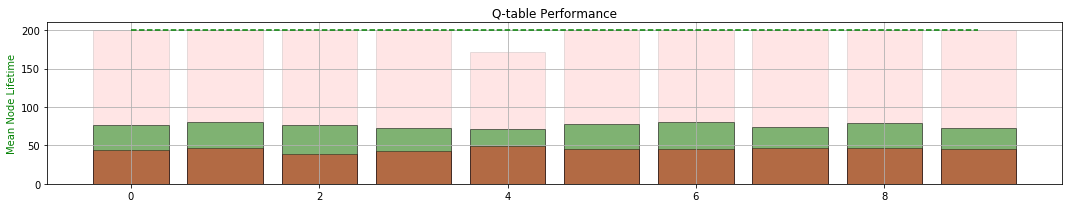

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 176.072	LOSS : 178.926	LOSS : 175.402	LOSS : 164.044	
Validating... MEAN TIME:  117.93
LOSS : 166.552	LOSS : 176.269	LOSS : 161.323	LOSS : 173.437	
Validating... MEAN TIME:  116.965
LOSS : 162.975	LOSS : 170.562	LOSS : 176.906	LOSS : 168.526	
Validating... MEAN TIME:  117.755
LOSS : 170.893	LOSS : 167.017	LOSS : 160.839	LOSS : 154.145	
Validating... MEAN TIME:  131.945
LOSS : 159.815	LOSS : 174.927	LOSS : 173.831	LOSS : 177.499	
Validating... MEAN TIME:  123.285
TRAINING TIME:0:00:46.682963


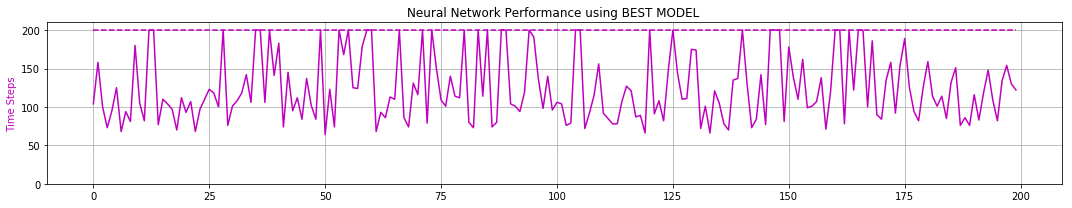

peak memory: 1398.72 MiB, increment: 1018.04 MiB
0 -max- [ 0.446  0.775  0.209  0.912]
0 -min- [-0.455 -1.307 -0.209 -0.842]

1 -max- [ 0.442  0.769  0.209  1.066]
1 -min- [-0.442 -1.273 -0.209 -0.804]

2 -max- [ 0.443  0.772  0.209  0.789]
2 -min- [-0.455 -1.281 -0.209 -1.019]

3 -max- [ 0.498  0.790  0.209  0.795]
3 -min- [-0.479 -1.318 -0.209 -1.052]

4 -max- [ 0.481  0.773  0.209  0.748]
4 -min- [-0.458 -1.300 -0.209 -0.797]

5 -max- [ 0.434  0.781  0.209  0.915]
5 -min- [-0.420 -1.287 -0.209 -0.817]

6 -max- [ 0.458  0.758  0.209  0.799]
6 -min- [-0.458 -1.281 -0.209 -0.944]

7 -max- [ 0.440  0.761  0.208  0.772]
7 -min- [-0.483 -1.296 -0.209 -0.743]

8 -max- [ 0.434  0.772  0.207  0.985]
8 -min- [-0.485 -1.282 -0.209 -0.834]

9 -max- [ 0.479  0.780  0.208  0.796]
9 -min- [-0.483 -1.461 -0.209 -0.830]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   71315
SMALLEST TIMESTEP: 42
LARGEST  TIMESTEP: 177
TOTAL SERIAL TIMESTEPS:   297144
TOTAL PARALLEL TIM

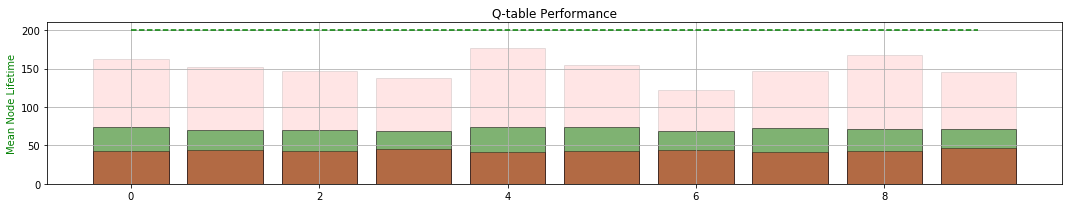

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 129.324	LOSS : 135.942	LOSS : 140.642	LOSS : 125.106	
Validating... MEAN TIME:  99.3
LOSS : 124.740	LOSS : 141.305	LOSS : 130.018	LOSS : 130.642	
Validating... MEAN TIME:  93.835
LOSS : 129.114	LOSS : 141.845	LOSS : 137.542	LOSS : 126.203	
Validating... MEAN TIME:  93.555
LOSS : 127.488	LOSS : 132.015	LOSS : 124.560	LOSS : 132.346	
Validating... MEAN TIME:  102.36
LOSS : 129.667	LOSS : 129.899	LOSS : 126.293	LOSS : 134.408	
Validating... MEAN TIME:  96.155
TRAINING TIME:0:00:42.335406


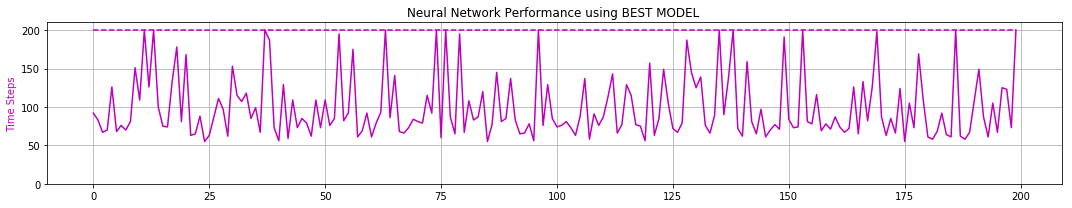

peak memory: 1397.02 MiB, increment: 1028.07 MiB
0 -max- [ 0.481  0.955  0.207  1.014]
0 -min- [-0.412 -1.325 -0.209 -0.823]

1 -max- [ 0.473  0.770  0.204  0.780]
1 -min- [-0.441 -1.429 -0.209 -0.912]

2 -max- [ 0.475  0.912  0.208  0.751]
2 -min- [-0.443 -1.299 -0.209 -0.985]

3 -max- [ 0.501  0.774  0.208  0.775]
3 -min- [-0.440 -1.300 -0.209 -0.734]

4 -max- [ 0.489  0.776  0.207  0.906]
4 -min- [-0.436 -1.288 -0.209 -1.086]

5 -max- [ 0.474  0.754  0.207  0.955]
5 -min- [-0.424 -1.281 -0.209 -0.835]

6 -max- [ 0.463  0.758  0.208  0.993]
6 -min- [-0.391 -1.272 -0.209 -0.793]

7 -max- [ 0.487  0.765  0.206  0.746]
7 -min- [-0.460 -1.321 -0.209 -0.802]

8 -max- [ 0.462  0.780  0.205  0.697]
8 -min- [-0.408 -1.247 -0.209 -0.792]

9 -max- [ 0.447  0.735  0.206  0.923]
9 -min- [-0.430 -1.273 -0.209 -0.796]

Quantization TIME:  0.01 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   65677
SMALLEST TIMESTEP: 35
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   362821
TOTAL PARALLEL TIM

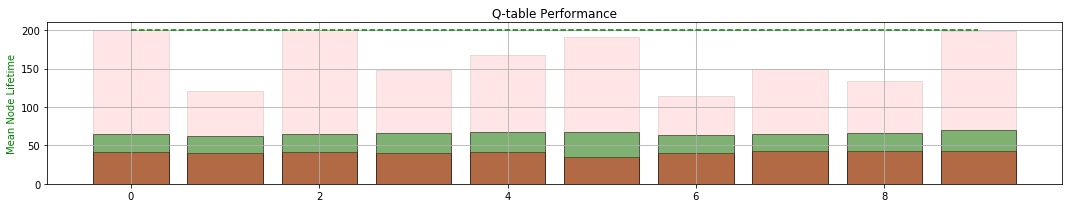

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 129.313	LOSS : 140.371	LOSS : 128.468	LOSS : 134.828	
Validating... MEAN TIME:  102.22
LOSS : 128.940	LOSS : 127.679	LOSS : 116.601	LOSS : 138.525	
Validating... MEAN TIME:  110.935
LOSS : 138.360	LOSS : 131.112	LOSS : 132.667	LOSS : 118.242	
Validating... MEAN TIME:  115.695
LOSS : 131.399	LOSS : 133.332	LOSS : 121.589	LOSS : 127.334	
Validating... MEAN TIME:  109.755
LOSS : 130.166	LOSS : 131.765	LOSS : 122.977	LOSS : 120.149	
Validating... MEAN TIME:  112.51
TRAINING TIME:0:00:44.844984


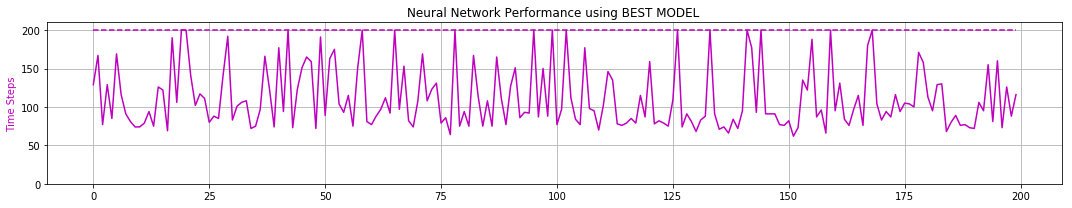

peak memory: 1461.32 MiB, increment: 1003.85 MiB
0 -max- [ 0.266  0.570  0.048  0.415]
0 -min- [-0.294 -1.251 -0.209 -0.803]

1 -max- [ 0.205  0.574  0.046  0.673]
1 -min- [-0.293 -1.249 -0.209 -0.982]

2 -max- [ 0.312  0.439  0.048  0.436]
2 -min- [-0.297 -1.089 -0.209 -0.817]

3 -max- [ 0.209  0.623  0.049  0.548]
3 -min- [-0.360 -1.302 -0.209 -0.833]

4 -max- [ 0.765  0.930  0.205  0.586]
4 -min- [-0.322 -1.139 -0.209 -1.084]

5 -max- [ 0.746  1.116  0.209  0.483]
5 -min- [-0.303 -1.118 -0.209 -1.093]

6 -max- [ 0.207  0.443  0.050  0.423]
6 -min- [-0.299 -1.105 -0.209 -0.821]

7 -max- [ 0.704  0.955  0.199  0.728]
7 -min- [-0.279 -1.138 -0.209 -0.872]

8 -max- [ 0.203  0.564  0.048  0.656]
8 -min- [-0.324 -1.251 -0.209 -1.057]

9 -max- [ 0.794  0.957  0.206  0.744]
9 -min- [-0.301 -1.097 -0.209 -1.124]

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   71954
SMALLEST TIMESTEP: 45
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   434775
TOTAL PARALLEL TIM

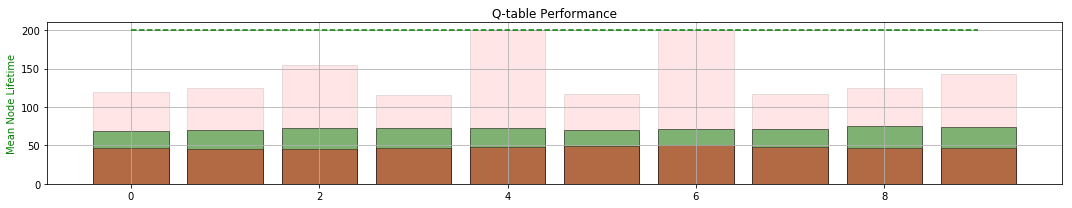

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 131.848	LOSS : 133.431	LOSS : 132.436	LOSS : 129.937	
Validating... MEAN TIME:  136.21
LOSS : 135.067	LOSS : 119.575	LOSS : 133.354	LOSS : 128.083	
Validating... MEAN TIME:  135.07
LOSS : 134.789	LOSS : 129.157	LOSS : 130.565	LOSS : 131.373	
Validating... MEAN TIME:  144.615
LOSS : 129.128	LOSS : 118.718	LOSS : 136.015	LOSS : 135.018	
Validating... MEAN TIME:  142.96
LOSS : 131.100	LOSS : 122.667	LOSS : 128.970	LOSS : 129.035	
Validating... MEAN TIME:  155.28
TRAINING TIME:0:00:49.814596


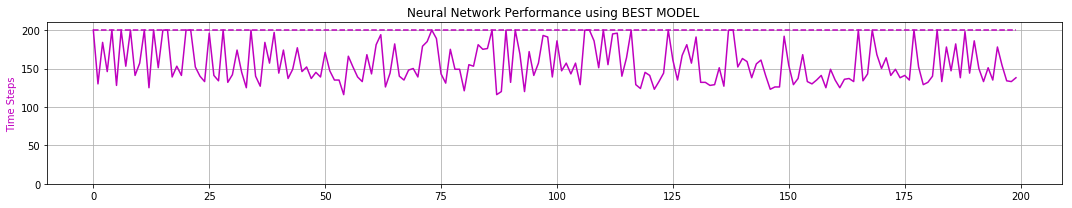

peak memory: 1455.85 MiB, increment: 1017.66 MiB
0 -max- [ 0.199  0.568  0.046  0.668]
0 -min- [-0.413 -1.277 -0.209 -0.805]

1 -max- [ 0.193  0.613  0.048  0.434]
1 -min- [-0.400 -1.088 -0.209 -0.969]

2 -max- [ 0.206  0.436  0.049  0.903]
2 -min- [-0.401 -1.272 -0.209 -1.257]

3 -max- [ 0.182  0.549  0.049  0.623]
3 -min- [-0.418 -1.267 -0.209 -0.862]

4 -max- [ 1.027  1.302  0.186  0.457]
4 -min- [-0.396 -1.102 -0.209 -0.798]

5 -max- [ 0.185  0.544  0.050  0.599]
5 -min- [-0.425 -1.276 -0.209 -0.946]

6 -max- [ 0.291  0.531  0.048  0.487]
6 -min- [-0.418 -1.266 -0.209 -0.909]

7 -max- [ 0.159  0.604  0.048  0.542]
7 -min- [-0.397 -1.264 -0.209 -1.081]

8 -max- [ 0.202  0.565  0.051  0.676]
8 -min- [-0.400 -1.132 -0.209 -1.071]

9 -max- [ 0.203  0.431  0.049  0.618]
9 -min- [-0.392 -1.275 -0.209 -0.806]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   91739
SMALLEST TIMESTEP: 72
LARGEST  TIMESTEP: 146
TOTAL SERIAL TIMESTEPS:   526514
TOTAL PARALLEL TIM

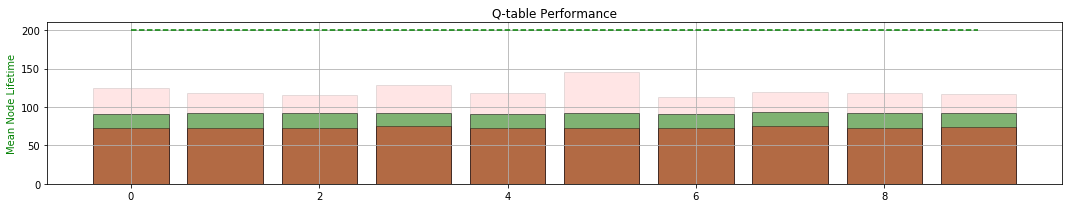

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 126.532	LOSS : 133.821	LOSS : 129.945	LOSS : 124.220	
Validating... MEAN TIME:  196.835
LOSS : 127.764	LOSS : 115.555	LOSS : 126.578	LOSS : 126.650	
Validating... MEAN TIME:  163.39
LOSS : 131.383	LOSS : 114.605	LOSS : 128.139	LOSS : 119.720	
Validating... MEAN TIME:  162.2
LOSS : 120.750	LOSS : 126.279	LOSS : 131.224	LOSS : 133.342	
Validating... MEAN TIME:  169.08
LOSS : 118.192	LOSS : 120.484	LOSS : 119.492	LOSS : 118.443	
Validating... MEAN TIME:  199.79
TRAINING TIME:0:00:56.365836


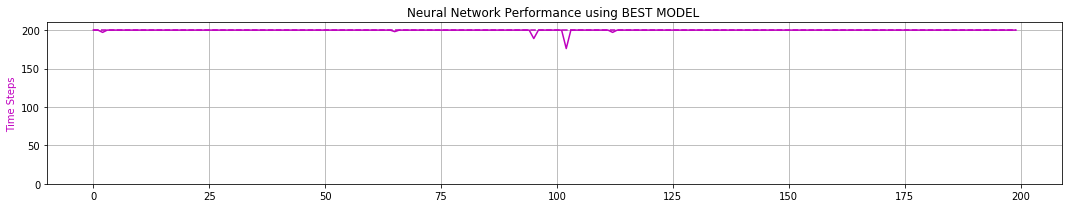

peak memory: 1433.49 MiB, increment: 1022.36 MiB
0 -max- [ 0.174  0.603  0.054  0.638]
0 -min- [-1.323 -1.861 -0.209 -0.880]

1 -max- [ 0.167  0.614  0.050  0.832]
1 -min- [-1.280 -1.864 -0.209 -0.988]

2 -max- [ 0.143  0.598  0.049  0.597]
2 -min- [-1.297 -1.858 -0.209 -0.867]

3 -max- [ 0.173  0.534  0.049  0.655]
3 -min- [-1.283 -1.868 -0.209 -0.808]

4 -max- [ 0.156  0.548  0.050  0.631]
4 -min- [-1.249 -1.869 -0.209 -0.793]

5 -max- [ 0.223  0.594  0.048  0.563]
5 -min- [-1.277 -1.869 -0.209 -0.815]

6 -max- [ 0.128  0.585  0.048  0.730]
6 -min- [-1.328 -1.861 -0.209 -1.067]

7 -max- [ 0.180  0.539  0.051  0.656]
7 -min- [-1.304 -1.983 -0.209 -1.075]

8 -max- [ 0.136  0.597  0.049  0.647]
8 -min- [-1.332 -2.003 -0.209 -0.908]

9 -max- [ 0.137  0.620  0.050  0.854]
9 -min- [-1.335 -2.001 -0.209 -0.887]

Quantization TIME:  0.01 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   113293
SMALLEST TIMESTEP: 31
LARGEST  TIMESTEP: 132
TOTAL SERIAL TIMESTEPS:   639807
TOTAL PARALLEL TI

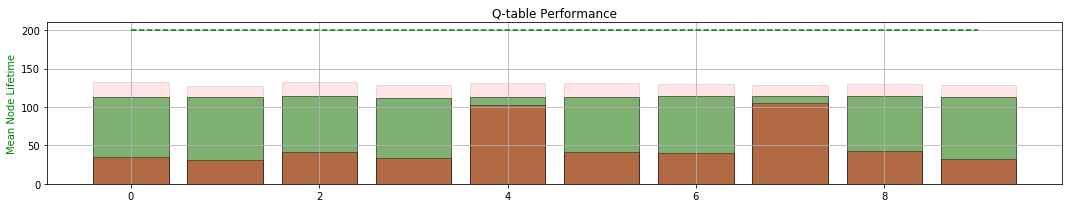

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 99.308	LOSS : 100.328	LOSS : 106.509	LOSS : 110.190	
Validating... MEAN TIME:  200.0
LOSS : 98.931	LOSS : 93.301	LOSS : 99.784	LOSS : 97.460	
Validating... MEAN TIME:  200.0
LOSS : 103.626	LOSS : 97.049	LOSS : 99.225	LOSS : 95.434	
Validating... MEAN TIME:  158.575
LOSS : 96.207	LOSS : 99.512	LOSS : 87.607	LOSS : 105.229	
Validating... MEAN TIME:  112.3
LOSS : 93.828	LOSS : 95.588	LOSS : 98.843	LOSS : 90.049	
Validating... MEAN TIME:  109.4
TRAINING TIME:0:00:53.089860


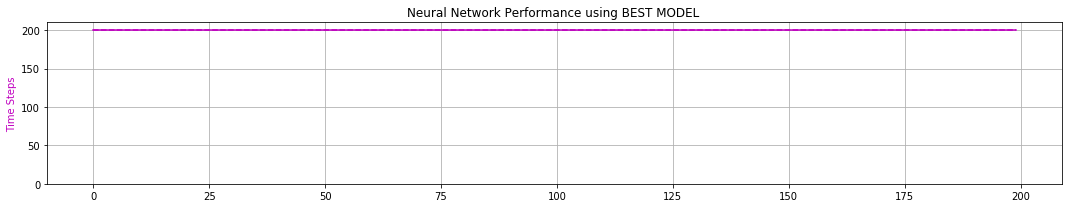

peak memory: 1437.90 MiB, increment: 978.37 MiB
0 -max- [ 0.163  0.767  0.110  0.993]
0 -min- [-2.399 -2.413 -0.206 -1.190]

1 -max- [ 0.156  0.628  0.120  1.058]
1 -min- [-2.400 -2.262 -0.204 -0.951]

2 -max- [ 0.167  0.619  0.114  0.877]
2 -min- [-2.400 -2.249 -0.198 -0.891]

3 -max- [ 0.159  0.618  0.109  0.835]
3 -min- [-2.400 -2.238 -0.207 -0.937]

4 -max- [ 0.183  0.607  0.108  0.807]
4 -min- [-2.400 -2.233 -0.196 -1.002]

5 -max- [ 0.139  0.612  0.121  1.019]
5 -min- [-2.400 -2.383 -0.209 -0.972]

6 -max- [ 0.168  0.597  0.113  1.007]
6 -min- [-2.400 -2.400 -0.205 -0.959]

7 -max- [ 0.145  0.633  0.106  1.030]
7 -min- [-2.400 -2.420 -0.200 -0.930]

8 -max- [ 0.152  0.627  0.116  1.011]
8 -min- [-2.400 -2.374 -0.201 -0.830]

9 -max- [ 0.165  0.634  0.122  0.911]
9 -min- [-2.399 -2.241 -0.205 -1.053]

Quantization TIME:  0.02 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   34872
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 99
TOTAL SERIAL TIMESTEPS:   674679
TOTAL PARALLEL TIME

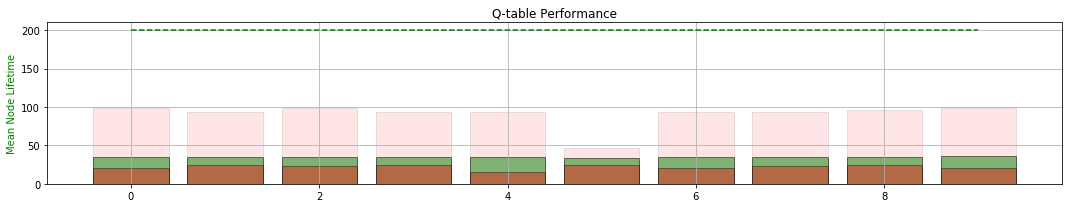

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 133.500	LOSS : 134.851	LOSS : 128.529	LOSS : 120.255	
Validating... MEAN TIME:  101.15
LOSS : 131.148	LOSS : 129.015	LOSS : 123.508	LOSS : 122.061	
Validating... MEAN TIME:  98.34
LOSS : 127.364	LOSS : 130.329	LOSS : 126.911	LOSS : 125.489	
Validating... MEAN TIME:  98.49
LOSS : 116.108	LOSS : 124.446	LOSS : 130.681	LOSS : 120.605	
Validating... MEAN TIME:  97.365
LOSS : 123.723	LOSS : 118.942	LOSS : 116.493	LOSS : 119.165	
Validating... MEAN TIME:  97.24
TRAINING TIME:0:00:43.483332


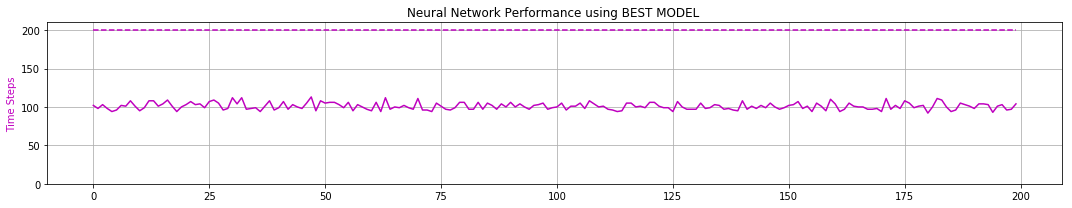

peak memory: 1440.20 MiB, increment: 1019.31 MiB
0 -max- [ 0.198  0.625  0.209  1.094]
0 -min- [-2.214 -2.417 -0.209 -1.190]

1 -max- [ 0.201  0.621  0.201  0.762]
1 -min- [-2.278 -2.266 -0.209 -1.066]

2 -max- [ 0.191  0.642  0.208  1.087]
2 -min- [-2.297 -2.435 -0.209 -1.107]

3 -max- [ 0.214  0.622  0.208  0.955]
3 -min- [-2.273 -2.582 -0.209 -1.014]

4 -max- [ 0.173  0.604  0.209  1.045]
4 -min- [-2.307 -2.602 -0.209 -1.204]

5 -max- [ 0.198  0.631  0.051  0.270]
5 -min- [-0.116 -0.897 -0.209 -0.901]

6 -max- [ 0.169  0.594  0.209  1.041]
6 -min- [-2.288 -2.583 -0.209 -0.967]

7 -max- [ 0.171  0.631  0.203  0.774]
7 -min- [-2.176 -2.267 -0.209 -1.079]

8 -max- [ 0.188  0.631  0.205  0.909]
8 -min- [-2.220 -2.421 -0.209 -1.096]

9 -max- [ 0.173  0.635  0.209  0.880]
9 -min- [-2.317 -2.453 -0.209 -0.971]

Quantization TIME:  0.02 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   35323
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 54
TOTAL SERIAL TIMESTEPS:   710002
TOTAL PARALLEL TIM

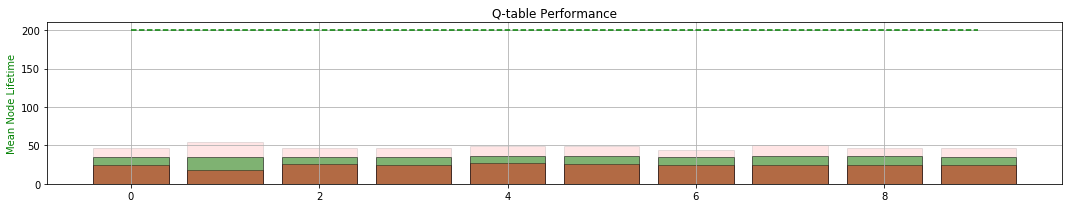

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 142.958	LOSS : 146.461	LOSS : 151.863	LOSS : 159.038	
Validating... MEAN TIME:  94.785
LOSS : 151.366	LOSS : 150.388	LOSS : 156.484	LOSS : 147.924	
Validating... MEAN TIME:  95.73
LOSS : 141.886	LOSS : 145.843	LOSS : 149.995	LOSS : 146.888	
Validating... MEAN TIME:  96.545
LOSS : 148.208	LOSS : 158.907	LOSS : 146.562	LOSS : 152.177	
Validating... MEAN TIME:  99.645
LOSS : 158.301	LOSS : 147.037	LOSS : 151.875	LOSS : 157.723	
Validating... MEAN TIME:  102.005
TRAINING TIME:0:00:42.956587


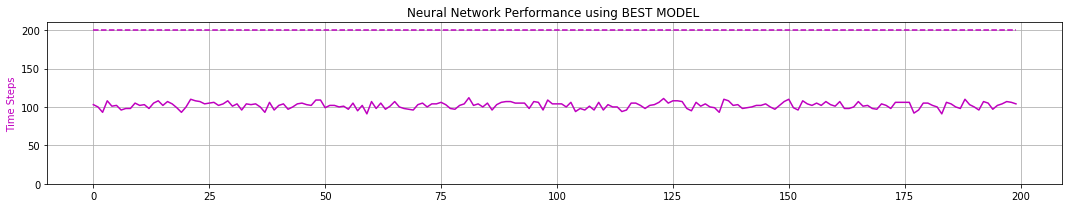

peak memory: 1440.68 MiB, increment: 978.12 MiB
0 -max- [ 0.193  0.624  0.049  0.270]
0 -min- [-0.177 -0.960 -0.209 -1.047]

1 -max- [ 0.177  0.629  0.050  0.321]
1 -min- [-0.247 -1.117 -0.209 -1.127]

2 -max- [ 0.206  0.628  0.048  0.171]
2 -min- [-0.210 -0.961 -0.209 -0.928]

3 -max- [ 0.159  0.615  0.048  0.341]
3 -min- [-0.194 -0.930 -0.209 -1.171]

4 -max- [ 0.191  0.638  0.051  0.253]
4 -min- [-0.173 -0.936 -0.209 -1.052]

5 -max- [ 0.169  0.630  0.049  0.286]
5 -min- [-0.144 -0.948 -0.209 -1.017]

6 -max- [ 0.162  0.627  0.050  0.312]
6 -min- [-0.205 -0.963 -0.209 -1.043]

7 -max- [ 0.188  0.638  0.050  0.293]
7 -min- [-0.144 -0.932 -0.209 -0.997]

8 -max- [ 0.169  0.640  0.049  0.301]
8 -min- [-0.173 -0.954 -0.209 -0.974]

9 -max- [ 0.158  0.632  0.050  0.277]
9 -min- [-0.165 -0.959 -0.209 -0.921]

Quantization TIME:  0.02 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   72854
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 91
TOTAL SERIAL TIMESTEPS:   782856
TOTAL PARALLEL TIME

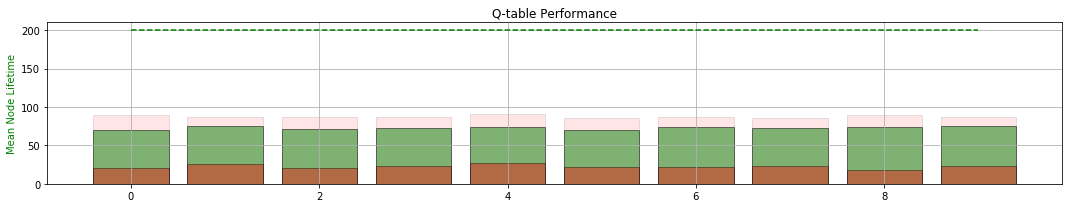

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 165.577	LOSS : 186.639	LOSS : 167.866	LOSS : 173.280	
Validating... MEAN TIME:  108.525
LOSS : 168.354	LOSS : 156.655	LOSS : 165.644	LOSS : 170.592	
Validating... MEAN TIME:  115.25
LOSS : 162.034	LOSS : 161.067	LOSS : 163.696	LOSS : 162.109	
Validating... MEAN TIME:  117.23
LOSS : 152.981	LOSS : 164.802	LOSS : 159.375	LOSS : 165.027	
Validating... MEAN TIME:  121.97
LOSS : 170.474	LOSS : 163.693	LOSS : 151.942	LOSS : 161.745	
Validating... MEAN TIME:  126.895
TRAINING TIME:0:00:47.426754


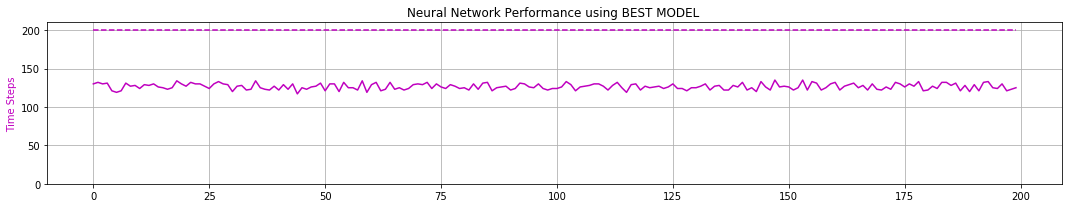

peak memory: 1460.21 MiB, increment: 1017.07 MiB
0 -max- [ 0.206  0.783  0.209  2.033]
0 -min- [-1.721 -3.027 -0.209 -1.146]

1 -max- [ 0.205  0.752  0.209  1.719]
1 -min- [-1.692 -2.818 -0.209 -1.058]

2 -max- [ 0.169  0.801  0.209  1.778]
2 -min- [-1.732 -2.802 -0.209 -1.287]

3 -max- [ 0.198  0.781  0.209  1.721]
3 -min- [-1.685 -2.813 -0.209 -1.081]

4 -max- [ 0.177  0.634  0.209  1.746]
4 -min- [-1.698 -2.799 -0.209 -1.063]

5 -max- [ 0.173  0.638  0.209  1.723]
5 -min- [-1.702 -2.817 -0.209 -1.091]

6 -max- [ 0.193  0.634  0.209  1.992]
6 -min- [-1.694 -3.011 -0.209 -1.095]

7 -max- [ 0.179  0.829  0.209  2.007]
7 -min- [-1.686 -2.978 -0.209 -1.101]

8 -max- [ 0.161  0.770  0.209  2.003]
8 -min- [-1.715 -2.986 -0.209 -1.099]

9 -max- [ 0.174  0.826  0.209  2.037]
9 -min- [-1.671 -2.995 -0.209 -1.154]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   30131
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 100
TOTAL SERIAL TIMESTEPS:   812987
TOTAL PARALLEL TI

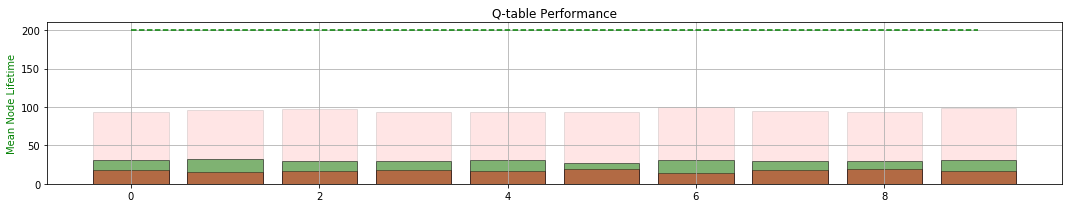

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 187.570	LOSS : 188.992	LOSS : 200.142	LOSS : 198.169	
Validating... MEAN TIME:  126.025
LOSS : 212.249	LOSS : 190.518	LOSS : 205.942	LOSS : 202.321	
Validating... MEAN TIME:  131.205
LOSS : 208.027	LOSS : 199.213	LOSS : 200.742	LOSS : 192.095	
Validating... MEAN TIME:  143.48
LOSS : 188.620	LOSS : 202.545	LOSS : 186.240	LOSS : 186.997	
Validating... MEAN TIME:  146.615
LOSS : 193.009	LOSS : 198.929	LOSS : 189.177	LOSS : 201.652	
Validating... MEAN TIME:  153.21
TRAINING TIME:0:00:49.963098


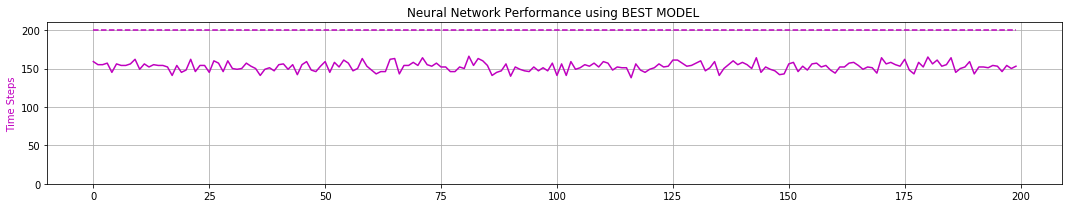

peak memory: 1487.48 MiB, increment: 1054.50 MiB
0 -max- [ 0.221  0.778  0.048  0.750]
0 -min- [-2.399 -2.811 -0.209 -1.177]

1 -max- [ 0.190  0.831  0.059  0.721]
1 -min- [-2.395 -2.800 -0.209 -1.450]

2 -max- [ 0.210  0.825  0.057  0.727]
2 -min- [-2.382 -2.896 -0.209 -1.232]

3 -max- [ 0.182  0.827  0.060  0.724]
3 -min- [-2.396 -2.794 -0.209 -1.283]

4 -max- [ 0.198  0.822  0.055  0.751]
4 -min- [-2.400 -2.812 -0.209 -1.273]

5 -max- [ 0.207  0.807  0.050  0.729]
5 -min- [-2.376 -2.794 -0.209 -1.276]

6 -max- [ 0.181  0.804  0.054  0.742]
6 -min- [-2.397 -2.811 -0.209 -1.232]

7 -max- [ 0.177  0.821  0.058  0.741]
7 -min- [-2.398 -2.801 -0.209 -1.223]

8 -max- [ 0.186  0.823  0.062  0.753]
8 -min- [-2.399 -2.793 -0.209 -1.186]

9 -max- [ 0.177  0.755  0.053  0.855]
9 -min- [-2.400 -2.960 -0.209 -1.108]

Quantization TIME:  0.01 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   83297
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 113
TOTAL SERIAL TIMESTEPS:   896284
TOTAL PARALLEL TI

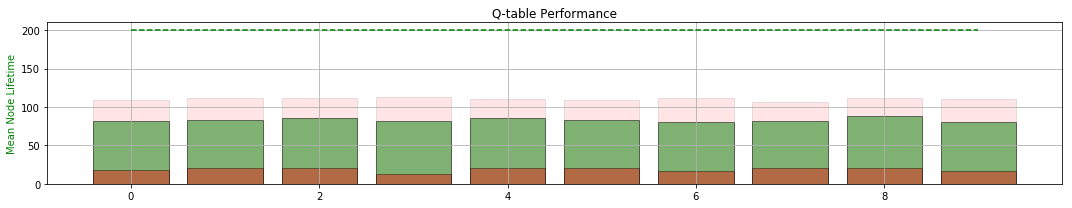

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 171.629	LOSS : 166.429	LOSS : 154.667	LOSS : 164.419	
Validating... MEAN TIME:  141.615
LOSS : 160.084	LOSS : 166.513	LOSS : 160.879	LOSS : 156.483	
Validating... MEAN TIME:  142.25
LOSS : 156.809	LOSS : 154.483	LOSS : 156.567	LOSS : 154.192	
Validating... MEAN TIME:  148.105
LOSS : 159.166	LOSS : 164.712	LOSS : 176.580	LOSS : 151.277	
Validating... MEAN TIME:  151.965
LOSS : 150.479	LOSS : 160.802	LOSS : 158.590	LOSS : 164.073	
Validating... MEAN TIME:  170.83
TRAINING TIME:0:00:52.567371


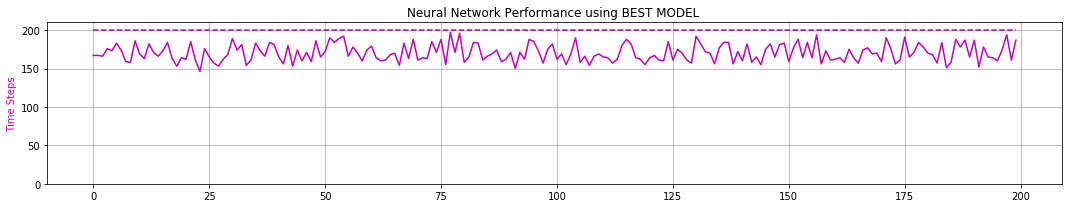

peak memory: 1455.34 MiB, increment: 1056.47 MiB
0 -max- [ 0.184  0.819  0.057  1.040]
0 -min- [-2.400 -2.926 -0.209 -1.232]

1 -max- [ 0.204  0.815  0.059  0.999]
1 -min- [-2.400 -2.962 -0.209 -1.392]

2 -max- [ 0.182  0.798  0.054  1.029]
2 -min- [-2.400 -2.936 -0.209 -1.214]

3 -max- [ 0.189  0.826  0.074  0.746]
3 -min- [-2.400 -2.781 -0.209 -1.292]

4 -max- [ 0.201  0.824  0.072  1.098]
4 -min- [-2.400 -2.973 -0.209 -1.185]

5 -max- [ 0.187  0.639  0.071  0.756]
5 -min- [-2.400 -2.785 -0.209 -1.039]

6 -max- [ 0.177  0.831  0.060  1.014]
6 -min- [-2.399 -2.778 -0.209 -1.262]

7 -max- [ 0.186  0.832  0.081  0.973]
7 -min- [-2.400 -2.776 -0.209 -1.249]

8 -max- [ 0.175  0.932  0.076  0.751]
8 -min- [-2.398 -2.785 -0.209 -1.318]

9 -max- [ 0.192  0.801  0.053  1.006]
9 -min- [-2.398 -2.969 -0.209 -1.153]

Quantization TIME:  0.01 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   102785
SMALLEST TIMESTEP: 17
LARGEST  TIMESTEP: 118
TOTAL SERIAL TIMESTEPS:   999069
TOTAL PARALLEL T

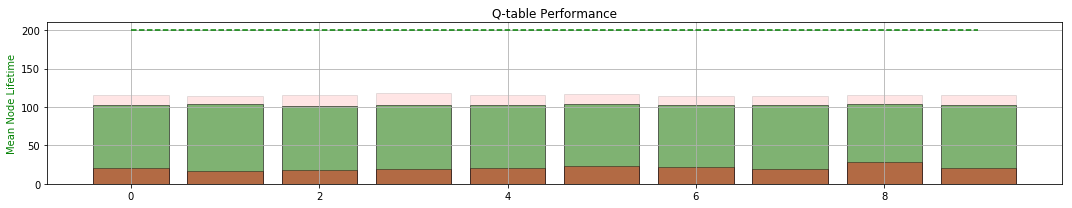

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 122.335	LOSS : 114.343	LOSS : 116.960	LOSS : 122.319	
Validating... MEAN TIME:  139.73
LOSS : 117.087	LOSS : 113.738	LOSS : 111.483	LOSS : 124.618	
Validating... MEAN TIME:  127.09
LOSS : 114.517	LOSS : 112.358	LOSS : 118.410	LOSS : 117.236	
Validating... MEAN TIME:  121.4
LOSS : 121.951	LOSS : 118.394	LOSS : 108.462	LOSS : 121.082	
Validating... MEAN TIME:  118.59
LOSS : 112.623	LOSS : 114.034	LOSS : 118.971	LOSS : 111.459	
Validating... MEAN TIME:  116.765
TRAINING TIME:0:00:47.903467


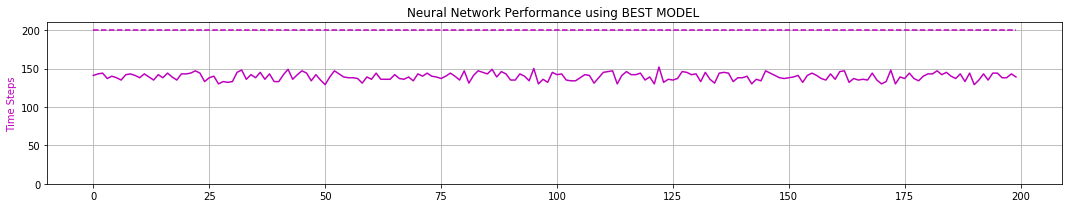

peak memory: 1399.08 MiB, increment: 941.49 MiB
0 -max- [ 0.204  0.803  0.051  0.730]
0 -min- [-2.400 -2.741 -0.209 -1.227]

1 -max- [ 0.182  0.808  0.049  0.716]
1 -min- [-2.400 -2.905 -0.205 -1.187]

2 -max- [ 0.189  0.821  0.050  0.879]
2 -min- [-2.400 -2.767 -0.208 -1.282]

3 -max- [ 0.201  0.806  0.050  0.695]
3 -min- [-2.400 -2.891 -0.206 -1.321]

4 -max- [ 0.187  0.827  0.049  0.678]
4 -min- [-2.400 -2.593 -0.209 -1.245]

5 -max- [ 0.181  0.753  0.050  0.754]
5 -min- [-2.399 -2.762 -0.204 -1.167]

6 -max- [ 0.186  0.831  0.050  0.658]
6 -min- [-2.399 -2.749 -0.208 -1.264]

7 -max- [ 0.175  0.787  0.050  0.685]
7 -min- [-2.400 -2.588 -0.208 -1.263]

8 -max- [ 0.192  0.827  0.048  0.931]
8 -min- [-2.400 -2.766 -0.207 -1.287]

9 -max- [ 0.197  0.833  0.050  0.760]
9 -min- [-2.400 -2.719 -0.209 -1.243]

Quantization TIME:  0.01 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   90025
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   1089094
TOTAL PARALLEL TI

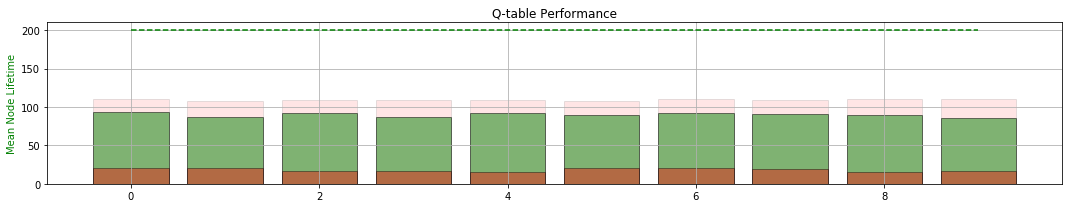

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 95.085	LOSS : 105.058	LOSS : 103.105	LOSS : 99.209	
Validating... MEAN TIME:  109.335
LOSS : 97.991	LOSS : 105.583	LOSS : 106.943	LOSS : 105.777	
Validating... MEAN TIME:  106.06
LOSS : 97.912	LOSS : 100.968	LOSS : 96.006	LOSS : 104.397	
Validating... MEAN TIME:  105.075
LOSS : 97.757	LOSS : 104.392	LOSS : 99.768	LOSS : 99.367	
Validating... MEAN TIME:  104.42
LOSS : 102.557	LOSS : 104.488	LOSS : 99.229	LOSS : 95.051	
Validating... MEAN TIME:  103.78
TRAINING TIME:0:00:44.948745


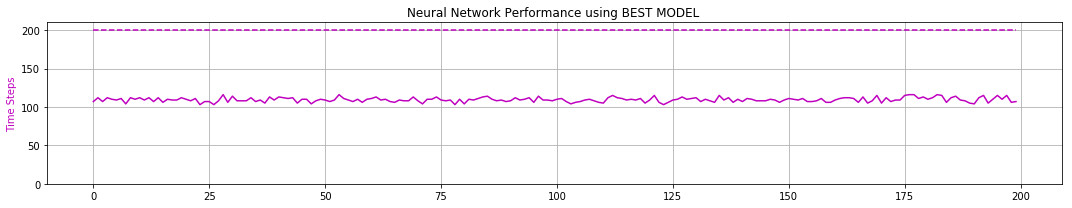

peak memory: 1450.62 MiB, increment: 1004.98 MiB
0 -max- [ 0.189  0.823  0.049  0.665]
0 -min- [-2.399 -3.128 -0.209 -1.268]

1 -max- [ 0.197  0.812  0.050  0.685]
1 -min- [-2.398 -2.730 -0.209 -1.251]

2 -max- [ 0.209  0.736  0.050  0.703]
2 -min- [-2.399 -2.768 -0.209 -1.128]

3 -max- [ 0.187  0.980  0.049  0.662]
3 -min- [-2.400 -2.890 -0.209 -1.357]

4 -max- [ 0.177  0.828  0.050  0.675]
4 -min- [-2.399 -2.773 -0.209 -1.202]

5 -max- [ 0.186  0.788  0.050  0.691]
5 -min- [-2.399 -3.125 -0.209 -1.192]

6 -max- [ 0.189  0.812  0.050  0.650]
6 -min- [-2.399 -2.882 -0.209 -1.296]

7 -max- [ 0.192  0.823  0.053  0.833]
7 -min- [-2.400 -3.111 -0.209 -1.237]

8 -max- [ 0.197  0.828  0.050  0.664]
8 -min- [-2.399 -2.921 -0.209 -1.350]

9 -max- [ 0.210  0.964  0.050  0.640]
9 -min- [-2.400 -3.118 -0.209 -1.352]

Quantization TIME:  0.01 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   29554
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 96
TOTAL SERIAL TIMESTEPS:   1118648
TOTAL PARALLEL TI

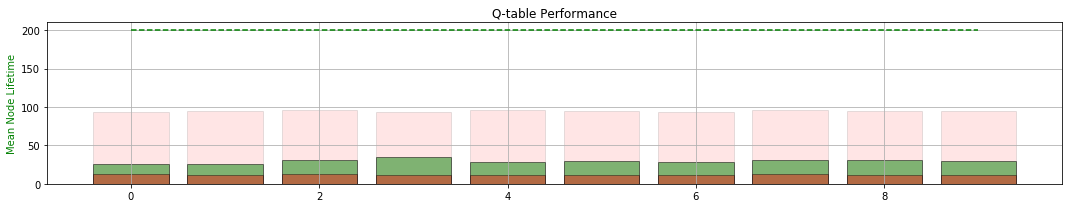

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 129.851	LOSS : 132.489	LOSS : 135.772	LOSS : 131.735	
Validating... MEAN TIME:  103.88
LOSS : 133.605	LOSS : 128.009	LOSS : 134.771	LOSS : 118.360	
Validating... MEAN TIME:  107.23
LOSS : 127.965	LOSS : 122.653	LOSS : 128.397	LOSS : 128.128	
Validating... MEAN TIME:  108.59
LOSS : 134.928	LOSS : 121.582	LOSS : 125.112	LOSS : 137.284	
Validating... MEAN TIME:  109.675
LOSS : 136.989	LOSS : 130.419	LOSS : 135.808	LOSS : 130.879	
Validating... MEAN TIME:  111.145
TRAINING TIME:0:00:45.800174


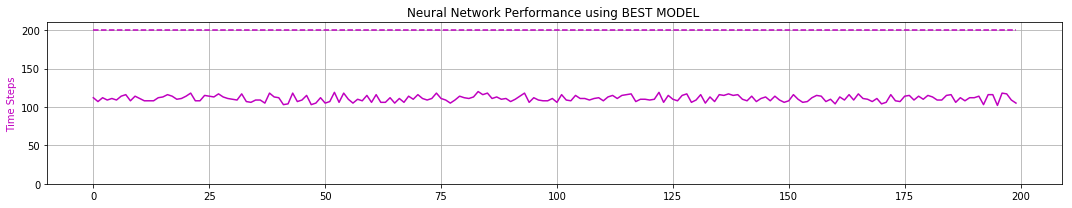

peak memory: 1489.68 MiB, increment: 978.17 MiB
0 -max- [ 0.206  0.951  0.050  0.389]
0 -min- [-2.394 -3.141 -0.209 -1.487]

1 -max- [ 0.226  1.182  0.052  0.619]
1 -min- [-2.393 -3.156 -0.209 -1.646]

2 -max- [ 0.203  0.829  0.049  0.751]
2 -min- [-2.395 -3.158 -0.209 -1.402]

3 -max- [ 0.200  1.115  0.060  0.603]
3 -min- [-2.397 -3.135 -0.209 -1.640]

4 -max- [ 0.204  0.830  0.050  0.620]
4 -min- [-2.392 -3.144 -0.209 -1.289]

5 -max- [ 0.198  1.129  0.050  0.497]
5 -min- [-2.396 -3.137 -0.209 -1.657]

6 -max- [ 0.210  1.011  0.048  0.577]
6 -min- [-2.395 -3.137 -0.209 -1.430]

7 -max- [ 0.214  1.016  0.050  0.531]
7 -min- [-2.399 -3.131 -0.209 -1.446]

8 -max- [ 0.214  1.183  0.050  0.706]
8 -min- [-2.397 -3.151 -0.209 -1.647]

9 -max- [ 0.198  1.005  0.049  0.607]
9 -min- [-2.397 -3.346 -0.209 -1.422]

Quantization TIME:  0.02 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   46517
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 100
TOTAL SERIAL TIMESTEPS:   1165165
TOTAL PARALLEL TI

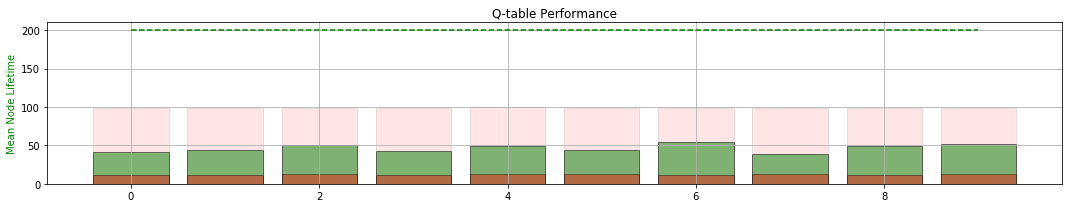

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 161.021	LOSS : 164.039	LOSS : 158.719	LOSS : 159.686	
Validating... MEAN TIME:  110.165
LOSS : 155.714	LOSS : 149.761	LOSS : 153.405	LOSS : 160.901	
Validating... MEAN TIME:  111.09
LOSS : 166.120	LOSS : 153.197	LOSS : 156.254	LOSS : 160.092	
Validating... MEAN TIME:  113.85
LOSS : 146.469	LOSS : 156.330	LOSS : 166.565	LOSS : 154.886	
Validating... MEAN TIME:  115.52
LOSS : 152.439	LOSS : 165.023	LOSS : 160.448	LOSS : 163.841	
Validating... MEAN TIME:  115.81
TRAINING TIME:0:00:46.089958


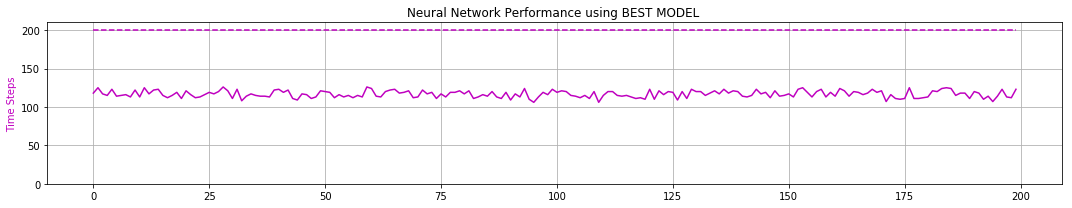

peak memory: 1459.31 MiB, increment: 1042.27 MiB
0 -max- [ 0.224  0.824  0.050  0.631]
0 -min- [-2.400 -3.337 -0.209 -1.404]

1 -max- [ 0.197  0.837  0.049  0.643]
1 -min- [-2.400 -3.346 -0.209 -1.413]

2 -max- [ 0.186  0.969  0.050  0.616]
2 -min- [-2.399 -3.347 -0.209 -1.414]

3 -max- [ 0.202  0.827  0.050  0.686]
3 -min- [-2.397 -3.344 -0.209 -1.187]

4 -max- [ 0.198  0.934  0.050  0.878]
4 -min- [-2.396 -3.525 -0.209 -1.363]

5 -max- [ 0.208  1.011  0.048  0.699]
5 -min- [-2.400 -3.347 -0.209 -1.374]

6 -max- [ 0.215  1.001  0.050  0.645]
6 -min- [-2.399 -3.347 -0.209 -1.414]

7 -max- [ 0.206  0.964  0.050  0.644]
7 -min- [-2.396 -3.338 -0.209 -1.411]

8 -max- [ 0.190  0.927  0.049  0.616]
8 -min- [-2.398 -3.348 -0.209 -1.479]

9 -max- [ 0.194  0.945  0.049  0.596]
9 -min- [-2.399 -3.344 -0.209 -1.386]

Quantization TIME:  0.01 minutes


ITERATION # 19
TOTAL EXPERIENCE GENERATED:   73644
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 104
TOTAL SERIAL TIMESTEPS:   1238809
TOTAL PARALLEL T

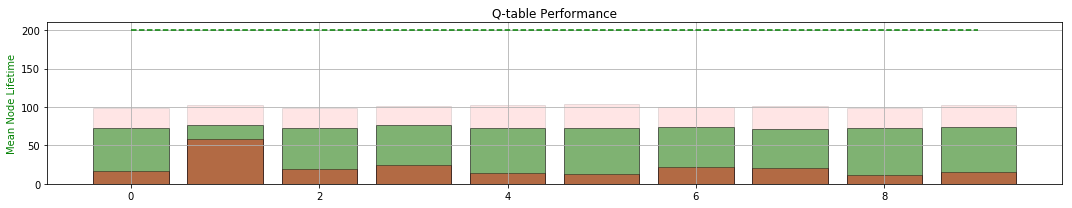

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 171.162	LOSS : 177.638	LOSS : 174.430	LOSS : 169.992	
Validating... MEAN TIME:  116.59
LOSS : 158.138	LOSS : 171.350	LOSS : 169.339	LOSS : 168.361	
Validating... MEAN TIME:  120.865
LOSS : 173.376	LOSS : 169.354	LOSS : 176.677	LOSS : 166.540	
Validating... MEAN TIME:  125.06
LOSS : 176.321	LOSS : 170.549	LOSS : 180.192	LOSS : 175.745	
Validating... MEAN TIME:  126.83
LOSS : 173.579	LOSS : 165.670	LOSS : 177.158	LOSS : 167.248	
Validating... MEAN TIME:  128.62
TRAINING TIME:0:00:46.492933


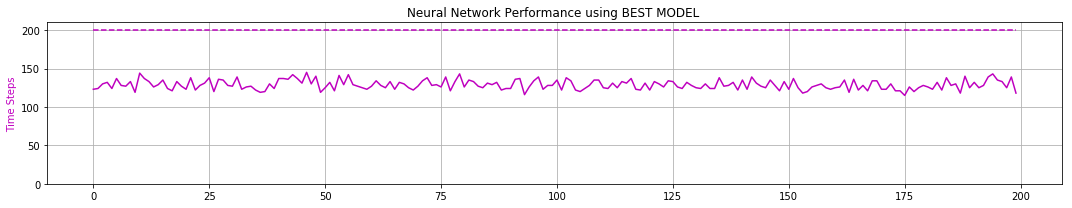

peak memory: 1452.15 MiB, increment: 977.91 MiB
0 -max- [ 0.187  0.811  0.049  0.630]
0 -min- [-2.399 -3.251 -0.209 -1.291]

1 -max- [ 0.177  0.967  0.050  0.598]
1 -min- [-2.400 -3.300 -0.209 -1.372]

2 -max- [ 0.193  0.821  0.050  0.595]
2 -min- [-2.395 -3.287 -0.209 -1.166]

3 -max- [ 0.183  0.935  0.050  0.495]
3 -min- [-2.393 -3.298 -0.209 -1.374]

4 -max- [ 0.200  1.009  0.054  0.632]
4 -min- [-2.391 -3.322 -0.209 -1.405]

5 -max- [ 0.205  0.826  0.050  0.623]
5 -min- [-2.399 -3.309 -0.209 -1.367]

6 -max- [ 0.202  1.019  0.053  0.626]
6 -min- [-2.397 -3.145 -0.209 -1.370]

7 -max- [ 0.182  0.828  0.049  0.598]
7 -min- [-2.399 -3.303 -0.209 -1.197]

8 -max- [ 0.185  0.975  0.050  0.624]
8 -min- [-2.399 -3.238 -0.209 -1.386]

9 -max- [ 0.193  0.974  0.048  0.584]
9 -min- [-2.397 -3.290 -0.209 -1.373]

Quantization TIME:  0.01 minutes


ITERATION # 20
TOTAL EXPERIENCE GENERATED:   93910
SMALLEST TIMESTEP: 46
LARGEST  TIMESTEP: 113
TOTAL SERIAL TIMESTEPS:   1332719
TOTAL PARALLEL TI

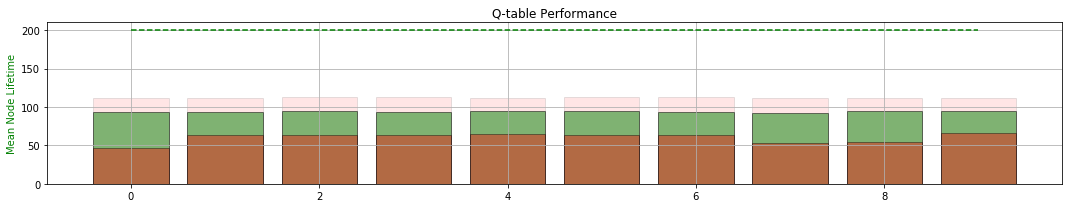

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 127.171	LOSS : 127.369	LOSS : 130.401	LOSS : 132.822	
Validating... MEAN TIME:  113.635
LOSS : 133.942	LOSS : 123.249	LOSS : 130.146	LOSS : 128.550	
Validating... MEAN TIME:  110.255
LOSS : 124.545	LOSS : 131.568	LOSS : 116.533	LOSS : 130.169	
Validating... MEAN TIME:  108.9
LOSS : 119.034	LOSS : 125.466	LOSS : 137.198	LOSS : 125.364	
Validating... MEAN TIME:  108.855
LOSS : 122.592	LOSS : 130.927	LOSS : 129.243	LOSS : 131.234	
Validating... MEAN TIME:  108.355
TRAINING TIME:0:00:46.170386


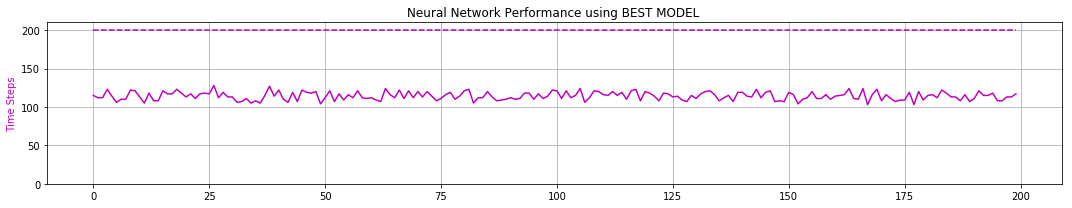

peak memory: 1481.74 MiB, increment: 1046.32 MiB
0 -max- [ 0.153  0.635  0.050  0.661]
0 -min- [-2.398 -3.259 -0.209 -1.040]

1 -max- [ 0.161  0.636  0.050  0.568]
1 -min- [-2.400 -3.146 -0.209 -1.051]

2 -max- [ 0.157  0.807  0.050  0.628]
2 -min- [-2.397 -3.157 -0.209 -1.180]

3 -max- [ 0.176  0.783  0.048  0.556]
3 -min- [-2.397 -3.157 -0.209 -1.162]

4 -max- [ 0.173  0.813  0.050  0.634]
4 -min- [-2.399 -3.155 -0.209 -1.128]

5 -max- [ 0.182  0.769  0.050  0.651]
5 -min- [-2.400 -3.146 -0.209 -1.117]

6 -max- [ 0.165  0.785  0.049  0.633]
6 -min- [-2.400 -3.277 -0.209 -1.194]

7 -max- [ 0.164  0.637  0.049  0.831]
7 -min- [-2.400 -3.153 -0.209 -1.115]

8 -max- [ 0.169  0.780  0.048  0.604]
8 -min- [-2.400 -3.163 -0.209 -1.101]

9 -max- [ 0.178  0.924  0.051  0.600]
9 -min- [-2.400 -3.150 -0.209 -1.330]

Quantization TIME:  0.01 minutes


ITERATION # 21
TOTAL EXPERIENCE GENERATED:   59747
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 76
TOTAL SERIAL TIMESTEPS:   1392466
TOTAL PARALLEL TI

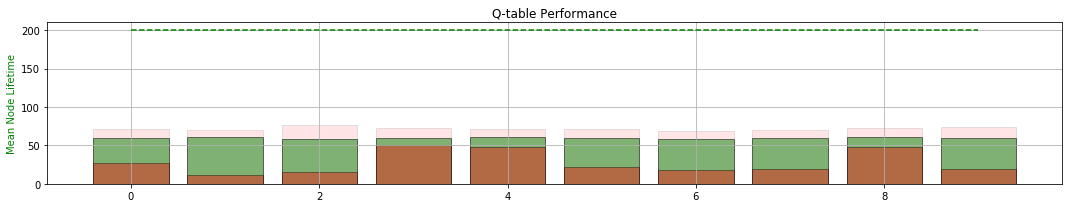

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 124.705	LOSS : 133.499	LOSS : 119.693	LOSS : 126.838	
Validating... MEAN TIME:  108.295
LOSS : 115.996	LOSS : 116.659	LOSS : 113.833	LOSS : 122.269	
Validating... MEAN TIME:  108.365
LOSS : 124.745	LOSS : 128.104	LOSS : 126.113	LOSS : 117.198	
Validating... MEAN TIME:  107.285
LOSS : 122.546	LOSS : 117.967	LOSS : 133.631	LOSS : 124.987	
Validating... MEAN TIME:  106.28
LOSS : 124.248	LOSS : 118.367	LOSS : 118.729	LOSS : 121.794	
Validating... MEAN TIME:  104.88
TRAINING TIME:0:00:44.685145


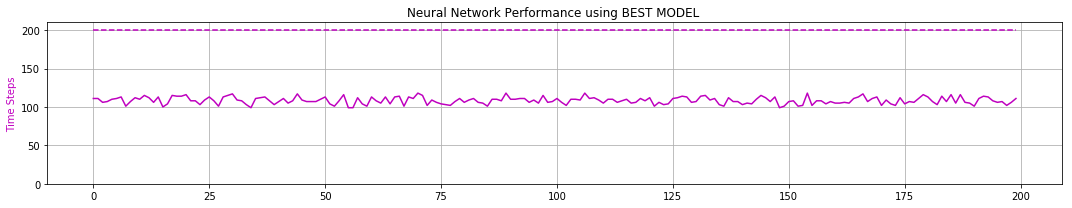

peak memory: 1424.79 MiB, increment: 1036.27 MiB
0 -max- [ 0.178  0.821  0.050  0.639]
0 -min- [-0.987 -2.157 -0.209 -1.166]

1 -max- [ 0.176  0.934  0.050  0.540]
1 -min- [-0.885 -2.021 -0.209 -1.363]

2 -max- [ 0.192  1.011  0.048  0.727]
2 -min- [-0.974 -2.021 -0.209 -1.361]

3 -max- [ 0.197  0.824  0.050  0.580]
3 -min- [-0.982 -2.157 -0.209 -1.169]

4 -max- [ 0.190  0.964  0.050  0.607]
4 -min- [-0.957 -2.053 -0.209 -1.354]

5 -max- [ 0.186  0.828  0.049  0.591]
5 -min- [-0.954 -2.072 -0.209 -1.235]

6 -max- [ 0.169  0.823  0.049  0.560]
6 -min- [-0.974 -2.058 -0.209 -1.283]

7 -max- [ 0.185  0.974  0.048  0.554]
7 -min- [-0.906 -1.965 -0.209 -1.366]

8 -max- [ 0.194  0.949  0.055  0.621]
8 -min- [-0.976 -2.148 -0.209 -1.361]

9 -max- [ 0.207  0.962  0.049  0.625]
9 -min- [-1.024 -2.146 -0.209 -1.466]

Quantization TIME:  0.01 minutes


ITERATION # 22
TOTAL EXPERIENCE GENERATED:   50103
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 93
TOTAL SERIAL TIMESTEPS:   1442569
TOTAL PARALLEL TI

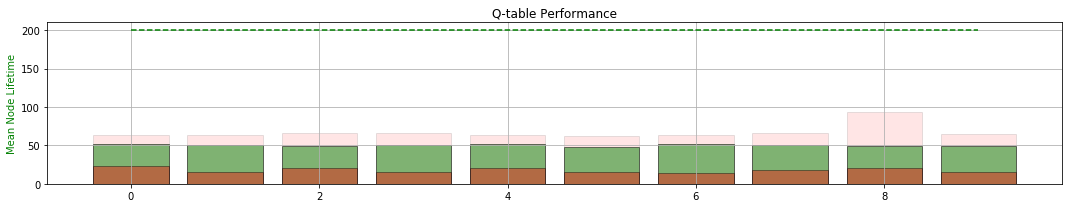

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 138.112	LOSS : 131.846	LOSS : 128.264	LOSS : 140.818	
Validating... MEAN TIME:  105.565
LOSS : 140.193	LOSS : 133.432	LOSS : 132.600	LOSS : 129.458	
Validating... MEAN TIME:  107.56
LOSS : 134.353	LOSS : 137.886	LOSS : 143.828	LOSS : 131.326	
Validating... MEAN TIME:  109.345
LOSS : 146.066	LOSS : 138.155	LOSS : 151.359	LOSS : 141.174	
Validating... MEAN TIME:  110.47
LOSS : 155.001	LOSS : 141.191	LOSS : 138.386	LOSS : 131.325	
Validating... MEAN TIME:  111.33
TRAINING TIME:0:00:46.133777


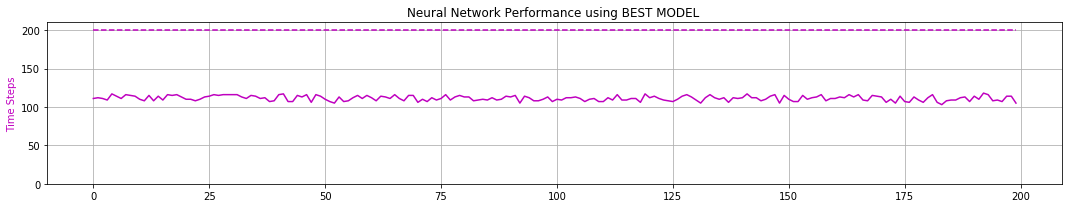

peak memory: 1455.82 MiB, increment: 1008.58 MiB
0 -max- [ 0.175  1.014  0.050  0.605]
0 -min- [-0.726 -1.808 -0.209 -1.445]

1 -max- [ 0.192  1.011  0.048  0.524]
1 -min- [-0.698 -1.801 -0.209 -1.361]

2 -max- [ 0.197  0.827  0.050  0.538]
2 -min- [-0.780 -1.822 -0.209 -1.224]

3 -max- [ 0.202  0.964  0.050  0.516]
3 -min- [-0.702 -1.829 -0.209 -1.363]

4 -max- [ 0.182  0.828  0.049  0.579]
4 -min- [-0.778 -1.833 -0.209 -1.198]

5 -max- [ 0.174  0.832  0.049  0.702]
5 -min- [-0.712 -1.823 -0.209 -1.225]

6 -max- [ 0.185  0.974  0.048  0.531]
6 -min- [-0.713 -1.857 -0.209 -1.366]

7 -max- [ 0.194  0.831  0.050  0.565]
7 -min- [-0.702 -1.774 -0.209 -1.282]

8 -max- [ 0.200  0.962  0.049  0.598]
8 -min- [-2.366 -3.466 -0.209 -1.362]

9 -max- [ 0.193  0.958  0.050  0.560]
9 -min- [-0.666 -1.832 -0.209 -1.368]

Quantization TIME:  0.01 minutes


ITERATION # 23
TOTAL EXPERIENCE GENERATED:   21348
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 96
TOTAL SERIAL TIMESTEPS:   1463917
TOTAL PARALLEL TI

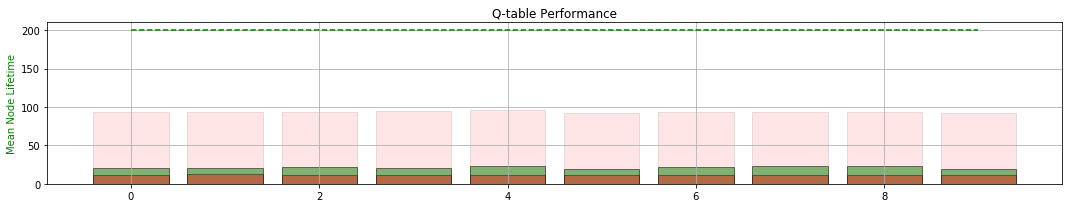

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 173.320	LOSS : 179.288	LOSS : 179.440	LOSS : 168.954	
Validating... MEAN TIME:  116.18
LOSS : 177.124	LOSS : 170.318	LOSS : 172.492	LOSS : 183.180	
Validating... MEAN TIME:  125.055
LOSS : 179.235	LOSS : 178.482	LOSS : 188.601	LOSS : 170.549	
Validating... MEAN TIME:  141.45
LOSS : 177.327	LOSS : 184.975	LOSS : 182.346	LOSS : 176.914	
Validating... MEAN TIME:  166.855
LOSS : 177.383	LOSS : 181.867	LOSS : 179.740	LOSS : 177.159	
Validating... MEAN TIME:  177.695
TRAINING TIME:0:00:51.541105


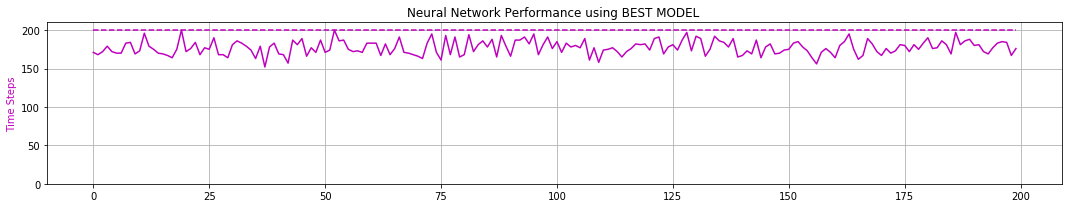

peak memory: 1440.05 MiB, increment: 1017.49 MiB
0 -max- [ 0.210  1.011  0.048  0.541]
0 -min- [-2.399 -2.888 -0.209 -1.374]

1 -max- [ 0.215  0.938  0.050  0.665]
1 -min- [-2.399 -2.984 -0.209 -1.424]

2 -max- [ 0.217  1.021  0.050  0.653]
2 -min- [-2.392 -2.954 -0.209 -1.375]

3 -max- [ 0.198  0.982  0.049  0.651]
3 -min- [-2.400 -2.930 -0.209 -1.389]

4 -max- [ 0.201  0.836  0.049  0.634]
4 -min- [-2.393 -2.968 -0.209 -1.441]

5 -max- [ 0.208  0.974  0.048  0.399]
5 -min- [-2.395 -2.595 -0.209 -1.373]

6 -max- [ 0.216  0.973  0.050  0.614]
6 -min- [-2.371 -2.984 -0.209 -1.551]

7 -max- [ 0.209  0.962  0.049  0.679]
7 -min- [-2.390 -2.977 -0.209 -1.376]

8 -max- [ 0.208  0.958  0.050  0.683]
8 -min- [-2.390 -2.984 -0.209 -1.375]

9 -max- [ 0.197  0.828  0.050  0.611]
9 -min- [-2.396 -2.962 -0.209 -1.411]

Quantization TIME:  0.02 minutes


ITERATION # 24
TOTAL EXPERIENCE GENERATED:   112781
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 126
TOTAL SERIAL TIMESTEPS:   1576698
TOTAL PARALLEL 

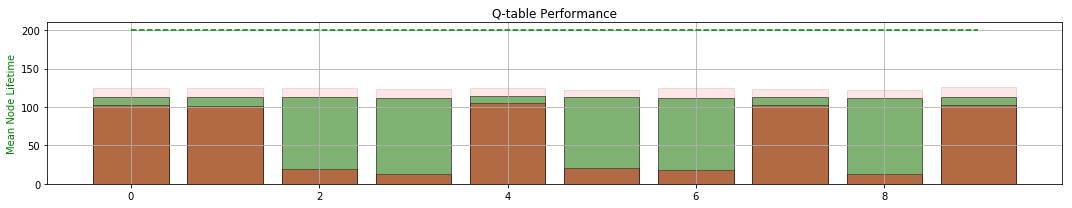

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 156.745	LOSS : 160.108	LOSS : 166.652	LOSS : 163.304	
Validating... MEAN TIME:  138.635
LOSS : 155.193	LOSS : 169.024	LOSS : 153.173	LOSS : 156.369	
Validating... MEAN TIME:  142.355
LOSS : 156.495	LOSS : 163.587	LOSS : 156.688	LOSS : 158.282	
Validating... MEAN TIME:  144.02
LOSS : 152.750	LOSS : 152.416	LOSS : 151.123	LOSS : 149.780	
Validating... MEAN TIME:  145.74
LOSS : 152.999	LOSS : 149.892	LOSS : 158.844	LOSS : 158.602	
Validating... MEAN TIME:  142.42
TRAINING TIME:0:00:50.899994


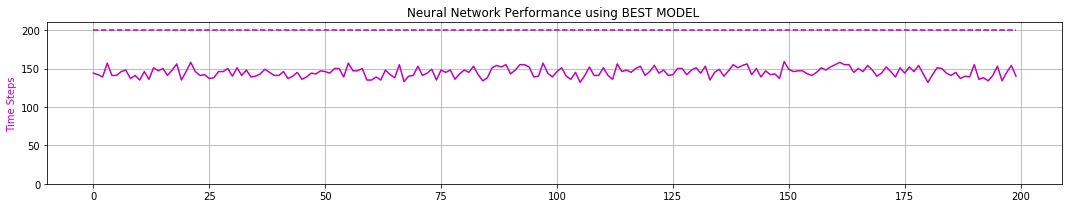

peak memory: 1478.25 MiB, increment: 1017.15 MiB
0 -max- [ 0.197  0.804  0.050  0.721]
0 -min- [-2.399 -2.261 -0.209 -1.266]

1 -max- [ 0.198  0.986  0.050  0.769]
1 -min- [-2.400 -2.241 -0.207 -1.373]

2 -max- [ 0.194  0.980  0.054  0.804]
2 -min- [-2.400 -2.229 -0.208 -1.326]

3 -max- [ 0.179  0.823  0.049  0.869]
3 -min- [-2.400 -2.247 -0.202 -1.210]

4 -max- [ 0.184  0.943  0.055  0.802]
4 -min- [-2.400 -2.337 -0.209 -1.350]

5 -max- [ 0.216  0.828  0.050  0.702]
5 -min- [-2.399 -2.251 -0.204 -1.280]

6 -max- [ 0.200  0.778  0.049  0.794]
6 -min- [-2.400 -2.259 -0.206 -1.235]

7 -max- [ 0.185  0.831  0.050  0.856]
7 -min- [-2.400 -2.235 -0.196 -1.255]

8 -max- [ 0.180  0.818  0.050  0.696]
8 -min- [-2.400 -2.197 -0.205 -1.223]

9 -max- [ 0.189  0.636  0.049  0.934]
9 -min- [-2.399 -2.208 -0.208 -1.009]

Quantization TIME:  0.02 minutes


ITERATION # 25
TOTAL EXPERIENCE GENERATED:   107011
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 122
TOTAL SERIAL TIMESTEPS:   1683709
TOTAL PARALLEL 

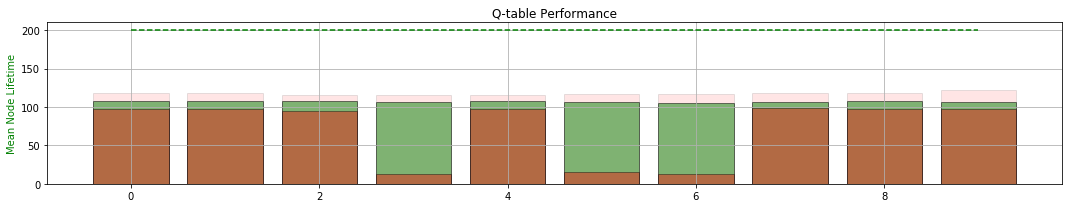

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 95.219	LOSS : 84.762	LOSS : 90.498	LOSS : 89.159	
Validating... MEAN TIME:  117.375
LOSS : 86.624	LOSS : 90.102	LOSS : 87.567	LOSS : 84.385	
Validating... MEAN TIME:  110.155
LOSS : 88.651	LOSS : 81.061	LOSS : 92.024	LOSS : 86.246	
Validating... MEAN TIME:  110.295
LOSS : 79.986	LOSS : 84.224	LOSS : 83.877	LOSS : 77.419	
Validating... MEAN TIME:  111.155
LOSS : 83.744	LOSS : 82.024	LOSS : 91.548	LOSS : 91.933	
Validating... MEAN TIME:  111.835
TRAINING TIME:0:00:45.520625


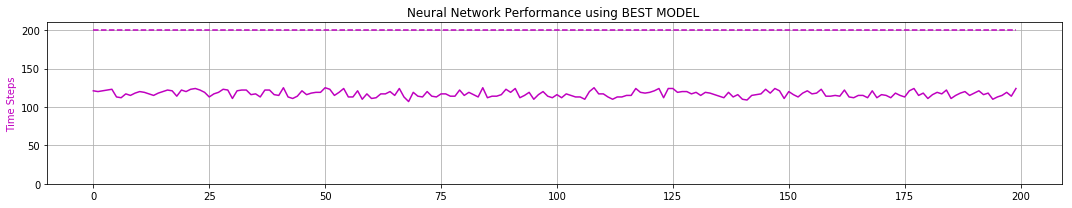

peak memory: 1469.89 MiB, increment: 1050.98 MiB
0 -max- [ 0.204  0.964  0.050  0.787]
0 -min- [-2.400 -2.769 -0.195 -1.352]

1 -max- [ 0.187  0.819  0.049  0.666]
1 -min- [-2.399 -2.586 -0.202 -1.208]

2 -max- [ 0.179  0.827  0.049  0.661]
2 -min- [-2.400 -2.621 -0.208 -1.300]

3 -max- [ 0.204  0.789  0.048  0.656]
3 -min- [-2.400 -2.615 -0.205 -1.340]

4 -max- [ 0.186  0.830  0.050  0.875]
4 -min- [-2.400 -2.787 -0.197 -1.267]

5 -max- [ 0.192  1.023  0.049  0.824]
5 -min- [-2.400 -2.724 -0.207 -1.484]

6 -max- [ 0.185  1.174  0.050  0.680]
6 -min- [-2.400 -2.602 -0.207 -1.797]

7 -max- [ 0.180  0.808  0.050  0.672]
7 -min- [-2.399 -2.588 -0.195 -1.127]

8 -max- [ 0.189  0.636  0.049  0.629]
8 -min- [-2.400 -2.592 -0.197 -1.019]

9 -max- [ 0.187  0.800  0.048  0.693]
9 -min- [-2.400 -2.596 -0.197 -1.262]

Quantization TIME:  0.01 minutes


ITERATION # 26
TOTAL EXPERIENCE GENERATED:   69139
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 104
TOTAL SERIAL TIMESTEPS:   1752848
TOTAL PARALLEL T

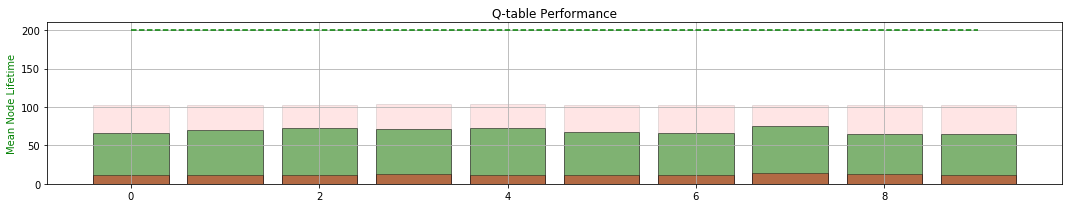

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 110.782	LOSS : 98.824	LOSS : 103.697	LOSS : 103.050	
Validating... MEAN TIME:  106.28
LOSS : 98.415	LOSS : 114.120	LOSS : 105.090	LOSS : 105.979	
Validating... MEAN TIME:  107.645
LOSS : 96.249	LOSS : 108.017	LOSS : 104.032	LOSS : 103.781	
Validating... MEAN TIME:  108.79
LOSS : 113.981	LOSS : 94.801	LOSS : 108.433	LOSS : 107.577	
Validating... MEAN TIME:  108.63
LOSS : 99.520	LOSS : 99.245	LOSS : 106.846	LOSS : 103.100	
Validating... MEAN TIME:  109.9
TRAINING TIME:0:00:44.344789


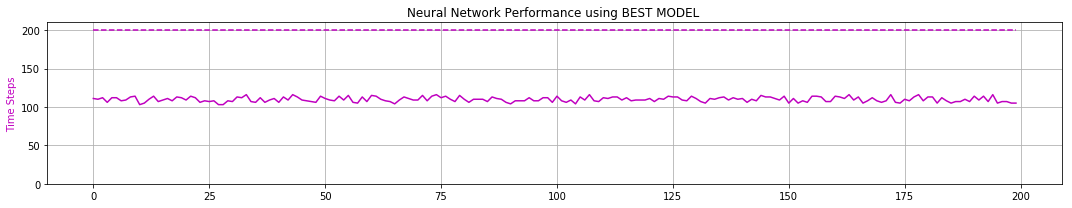

peak memory: 1455.35 MiB, increment: 977.85 MiB
0 -max- [ 0.197  0.829  0.049  0.598]
0 -min- [-2.400 -2.949 -0.209 -1.352]

1 -max- [ 0.200  0.944  0.049  0.652]
1 -min- [-2.399 -2.972 -0.209 -1.492]

2 -max- [ 0.201  0.974  0.048  0.606]
2 -min- [-2.399 -2.961 -0.209 -1.373]

3 -max- [ 0.210  1.022  0.050  0.666]
3 -min- [-2.399 -2.937 -0.209 -1.501]

4 -max- [ 0.202  0.962  0.049  0.648]
4 -min- [-2.399 -2.955 -0.209 -1.376]

5 -max- [ 0.208  1.152  0.050  0.634]
5 -min- [-2.399 -2.904 -0.209 -1.652]

6 -max- [ 0.181  0.993  0.050  0.641]
6 -min- [-2.400 -2.915 -0.209 -1.492]

7 -max- [ 0.200  0.965  0.049  0.577]
7 -min- [-2.398 -2.950 -0.209 -1.460]

8 -max- [ 0.193  1.188  0.048  0.726]
8 -min- [-2.400 -2.957 -0.209 -1.659]

9 -max- [ 0.186  1.023  0.049  0.612]
9 -min- [-2.400 -2.974 -0.209 -1.505]

Quantization TIME:  0.02 minutes


ITERATION # 27
TOTAL EXPERIENCE GENERATED:   56558
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 101
TOTAL SERIAL TIMESTEPS:   1809406
TOTAL PARALLEL TI

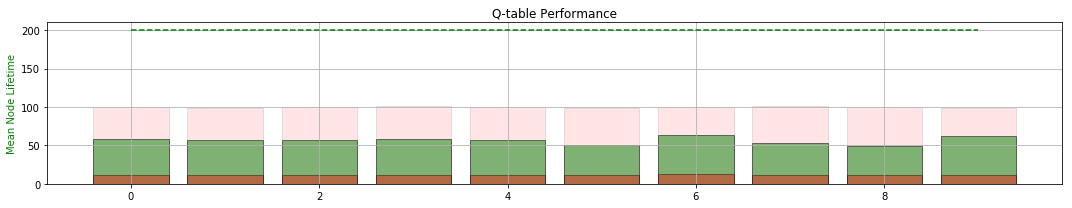

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 127.736	LOSS : 119.225	LOSS : 119.381	LOSS : 128.729	
Validating... MEAN TIME:  108.55
LOSS : 127.085	LOSS : 124.572	LOSS : 122.535	LOSS : 121.979	
Validating... MEAN TIME:  111.03
LOSS : 127.753	LOSS : 121.459	LOSS : 122.315	LOSS : 127.107	
Validating... MEAN TIME:  112.94
LOSS : 120.156	LOSS : 118.444	LOSS : 126.559	LOSS : 125.623	
Validating... MEAN TIME:  115.83
LOSS : 122.989	LOSS : 124.129	LOSS : 116.434	LOSS : 126.647	
Validating... MEAN TIME:  118.935
TRAINING TIME:0:00:44.039542


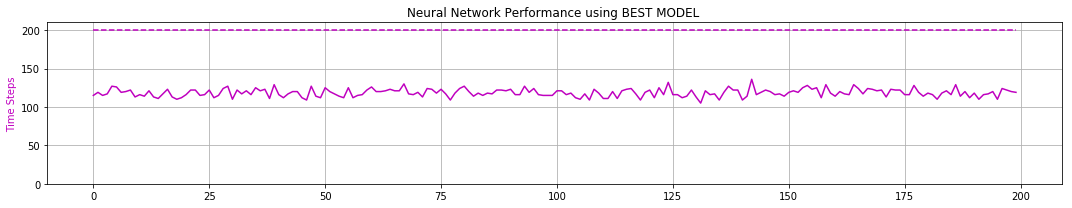

peak memory: 1435.81 MiB, increment: 977.73 MiB
0 -max- [ 0.204  1.021  0.049  0.591]
0 -min- [-2.400 -3.154 -0.209 -1.492]

1 -max- [ 0.204  1.169  0.048  0.677]
1 -min- [-2.400 -3.145 -0.209 -1.662]

2 -max- [ 0.218  1.198  0.054  0.776]
2 -min- [-2.400 -3.144 -0.209 -1.670]

3 -max- [ 0.210  0.985  0.049  0.768]
3 -min- [-2.399 -3.137 -0.209 -1.682]

4 -max- [ 0.210  1.152  0.050  0.626]
4 -min- [-2.399 -3.149 -0.209 -1.680]

5 -max- [ 0.198  1.219  0.050  0.602]
5 -min- [-2.399 -3.137 -0.209 -1.681]

6 -max- [ 0.210  1.194  0.049  0.601]
6 -min- [-2.398 -3.148 -0.209 -1.673]

7 -max- [ 0.208  1.188  0.048  0.648]
7 -min- [-2.398 -3.148 -0.209 -1.659]

8 -max- [ 0.198  1.023  0.049  0.590]
8 -min- [-2.397 -3.143 -0.209 -1.543]

9 -max- [ 0.209  1.184  0.050  0.645]
9 -min- [-2.400 -3.146 -0.209 -1.661]

Quantization TIME:  0.02 minutes


ITERATION # 28
TOTAL EXPERIENCE GENERATED:   87234
SMALLEST TIMESTEP: 17
LARGEST  TIMESTEP: 106
TOTAL SERIAL TIMESTEPS:   1896640
TOTAL PARALLEL TI

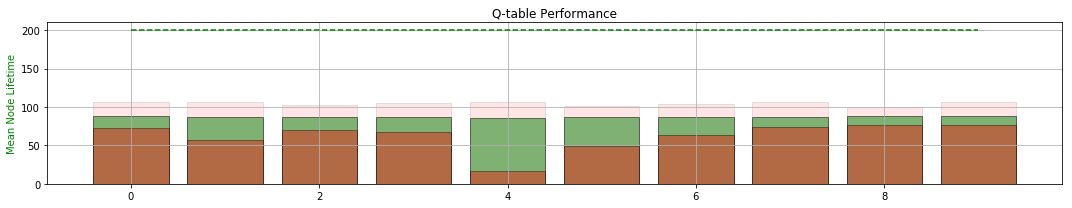

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 121.034	LOSS : 143.456	LOSS : 122.685	LOSS : 125.242	
Validating... MEAN TIME:  116.175
LOSS : 129.684	LOSS : 125.600	LOSS : 134.290	LOSS : 132.443	
Validating... MEAN TIME:  116.125
LOSS : 112.567	LOSS : 128.685	LOSS : 135.710	LOSS : 126.588	
Validating... MEAN TIME:  113.735
LOSS : 124.144	LOSS : 126.331	LOSS : 124.535	LOSS : 116.740	
Validating... MEAN TIME:  112.955
LOSS : 127.605	LOSS : 131.227	LOSS : 126.196	LOSS : 131.792	
Validating... MEAN TIME:  110.82
TRAINING TIME:0:00:44.775044


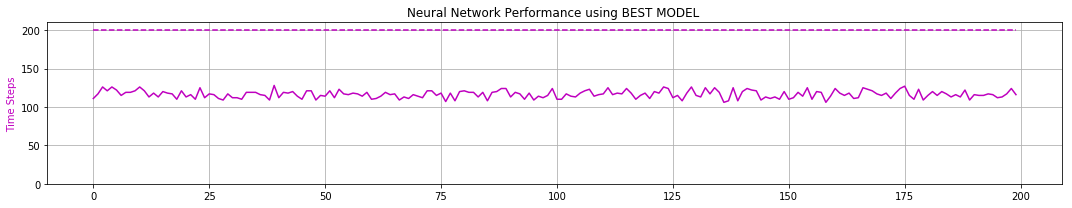

peak memory: 1435.83 MiB, increment: 1016.68 MiB
0 -max- [ 0.172  0.974  0.048  0.622]
0 -min- [-2.398 -3.135 -0.209 -1.366]

1 -max- [ 0.186  0.956  0.050  0.625]
1 -min- [-2.386 -3.132 -0.209 -1.460]

2 -max- [ 0.178  0.962  0.049  0.615]
2 -min- [-2.361 -3.117 -0.209 -1.362]

3 -max- [ 0.171  0.957  0.050  0.611]
3 -min- [-2.368 -3.117 -0.209 -1.359]

4 -max- [ 0.174  0.839  0.050  0.621]
4 -min- [-2.399 -3.127 -0.209 -1.392]

5 -max- [ 0.176  0.827  0.049  0.560]
5 -min- [-2.394 -3.110 -0.209 -1.217]

6 -max- [ 0.169  0.993  0.048  0.772]
6 -min- [-2.399 -3.137 -0.209 -1.364]

7 -max- [ 0.162  0.827  0.049  0.669]
7 -min- [-2.375 -3.132 -0.209 -1.166]

8 -max- [ 0.195  0.930  0.050  0.845]
8 -min- [-2.383 -3.147 -0.209 -1.357]

9 -max- [ 0.176  0.982  0.050  0.615]
9 -min- [-2.387 -3.135 -0.209 -1.448]

Quantization TIME:  0.01 minutes


ITERATION # 29
TOTAL EXPERIENCE GENERATED:   80216
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 95
TOTAL SERIAL TIMESTEPS:   1976856
TOTAL PARALLEL TI

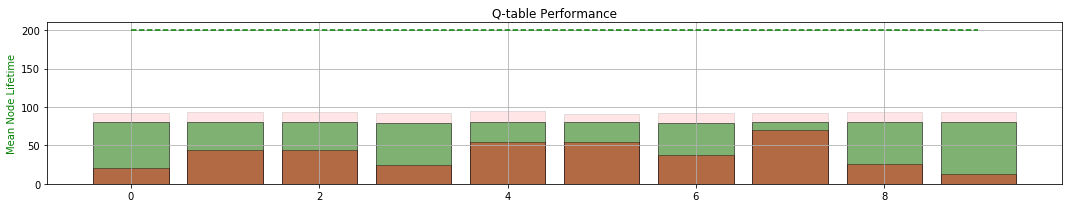

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 120.447	LOSS : 116.027	LOSS : 111.342	LOSS : 126.320	
Validating... MEAN TIME:  107.305
LOSS : 114.532	LOSS : 113.578	LOSS : 119.479	LOSS : 122.020	
Validating... MEAN TIME:  108.545
LOSS : 116.348	LOSS : 112.118	LOSS : 112.256	LOSS : 113.990	
Validating... MEAN TIME:  107.22
LOSS : 120.219	LOSS : 112.798	LOSS : 106.273	LOSS : 115.242	
Validating... MEAN TIME:  108.495
LOSS : 117.902	LOSS : 115.747	LOSS : 110.572	LOSS : 111.882	
Validating... MEAN TIME:  108.745
TRAINING TIME:0:00:44.738880


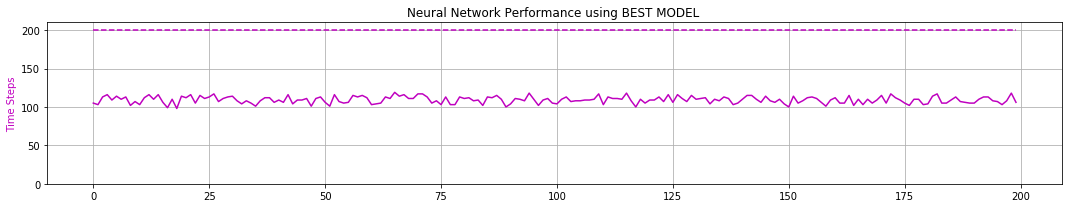

peak memory: 1420.22 MiB, increment: 1036.60 MiB
0 -max- [ 0.186  0.833  0.050  0.666]
0 -min- [-1.876 -2.695 -0.209 -1.268]

1 -max- [ 0.178  0.962  0.049  0.617]
1 -min- [-1.821 -2.692 -0.209 -1.362]

2 -max- [ 0.171  0.979  0.050  0.763]
2 -min- [-1.851 -2.612 -0.209 -1.393]

3 -max- [ 0.165  0.816  0.050  0.612]
3 -min- [-1.751 -2.586 -0.209 -1.158]

4 -max- [ 0.176  0.824  0.049  0.586]
4 -min- [-1.756 -2.710 -0.209 -1.164]

5 -max- [ 0.182  0.993  0.048  0.713]
5 -min- [-1.790 -2.591 -0.209 -1.364]

6 -max- [ 0.162  0.827  0.049  0.584]
6 -min- [-1.750 -2.600 -0.209 -1.166]

7 -max- [ 0.175  0.930  0.050  0.838]
7 -min- [-1.763 -2.715 -0.209 -1.357]

8 -max- [ 0.170  0.819  0.050  0.581]
8 -min- [-1.754 -2.609 -0.209 -1.168]

9 -max- [ 0.183  0.822  0.050  0.565]
9 -min- [-1.830 -2.582 -0.209 -1.197]

Quantization TIME:  0.01 minutes


ITERATION # 30
TOTAL EXPERIENCE GENERATED:   67643
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 105
TOTAL SERIAL TIMESTEPS:   2044499
TOTAL PARALLEL T

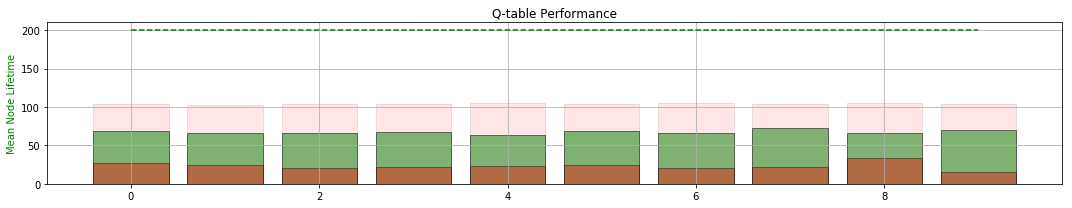

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 126.834	LOSS : 110.193	LOSS : 114.315	LOSS : 121.121	
Validating... MEAN TIME:  107.91
LOSS : 114.266	LOSS : 113.568	LOSS : 114.838	LOSS : 118.002	
Validating... MEAN TIME:  108.55
LOSS : 111.206	LOSS : 119.504	LOSS : 120.455	LOSS : 122.793	
Validating... MEAN TIME:  112.185
LOSS : 126.419	LOSS : 116.769	LOSS : 115.869	LOSS : 119.887	
Validating... MEAN TIME:  113.68
LOSS : 123.930	LOSS : 127.239	LOSS : 117.486	LOSS : 118.586	
Validating... MEAN TIME:  115.87
TRAINING TIME:0:00:45.496777


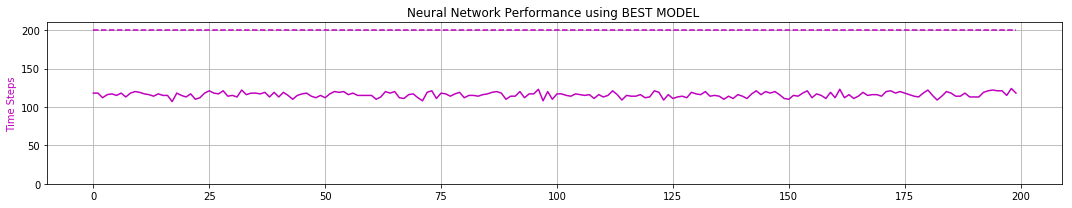

peak memory: 1459.29 MiB, increment: 1017.20 MiB
0 -max- [ 0.178  0.962  0.049  0.615]
0 -min- [-2.398 -3.248 -0.209 -1.362]

1 -max- [ 0.177  0.957  0.050  0.578]
1 -min- [-2.400 -3.150 -0.209 -1.359]

2 -max- [ 0.165  0.821  0.050  0.606]
2 -min- [-2.399 -3.276 -0.209 -1.275]

3 -max- [ 0.176  0.827  0.049  0.600]
3 -min- [-2.399 -3.242 -0.209 -1.232]

4 -max- [ 0.169  0.993  0.048  0.637]
4 -min- [-2.400 -3.156 -0.209 -1.364]

5 -max- [ 0.162  0.827  0.049  0.633]
5 -min- [-2.396 -3.155 -0.209 -1.166]

6 -max- [ 0.175  0.930  0.050  0.591]
6 -min- [-2.397 -3.158 -0.209 -1.357]

7 -max- [ 0.176  0.831  0.050  0.592]
7 -min- [-2.397 -3.157 -0.209 -1.172]

8 -max- [ 0.197  0.822  0.050  0.720]
8 -min- [-2.397 -3.246 -0.209 -1.231]

9 -max- [ 0.182  0.944  0.050  0.605]
9 -min- [-2.400 -3.282 -0.209 -1.361]

Quantization TIME:  0.02 minutes


ITERATION # 31
TOTAL EXPERIENCE GENERATED:   60635
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 104
TOTAL SERIAL TIMESTEPS:   2105134
TOTAL PARALLEL T

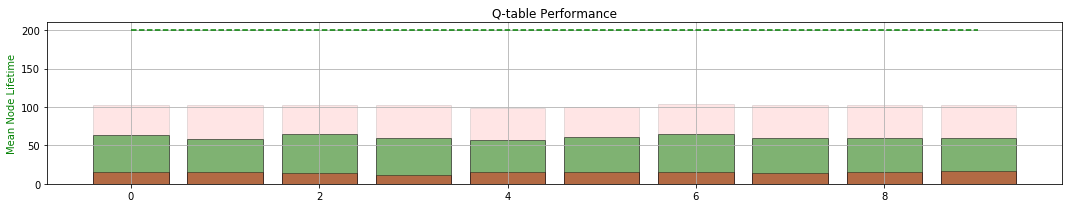

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 128.192	LOSS : 133.325	LOSS : 129.600	LOSS : 134.787	
Validating... MEAN TIME:  120.65
LOSS : 141.422	LOSS : 134.531	LOSS : 141.182	LOSS : 142.918	
Validating... MEAN TIME:  126.63
LOSS : 137.343	LOSS : 139.611	LOSS : 131.079	LOSS : 125.741	
Validating... MEAN TIME:  130.665
LOSS : 134.389	LOSS : 138.721	LOSS : 136.913	LOSS : 134.435	
Validating... MEAN TIME:  133.575
LOSS : 129.427	LOSS : 129.051	LOSS : 140.570	LOSS : 132.906	
Validating... MEAN TIME:  135.665
TRAINING TIME:0:00:49.494369


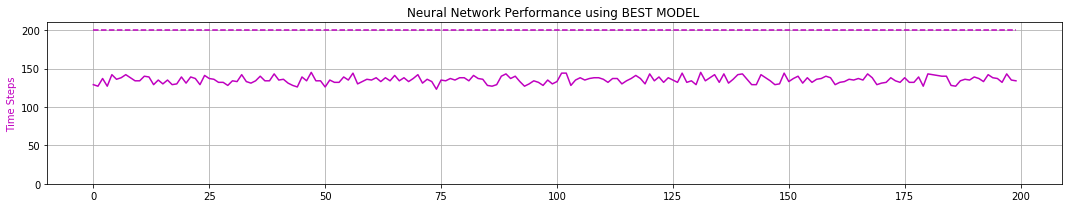

peak memory: 1473.26 MiB, increment: 1074.04 MiB
0 -max- [ 0.193  0.958  0.050  0.857]
0 -min- [-2.400 -2.917 -0.209 -1.399]

1 -max- [ 0.181  0.828  0.050  0.817]
1 -min- [-2.400 -2.892 -0.209 -1.327]

2 -max- [ 0.192  0.828  0.049  0.692]
2 -min- [-2.400 -2.806 -0.209 -1.319]

3 -max- [ 0.191  0.994  0.048  0.744]
3 -min- [-2.399 -2.978 -0.209 -1.377]

4 -max- [ 0.186  0.827  0.049  0.697]
4 -min- [-2.399 -2.889 -0.209 -1.206]

5 -max- [ 0.194  0.989  0.050  0.835]
5 -min- [-2.400 -2.901 -0.209 -1.374]

6 -max- [ 0.207  0.830  0.050  0.720]
6 -min- [-2.399 -2.913 -0.209 -1.199]

7 -max- [ 0.207  0.934  0.050  1.215]
7 -min- [-2.399 -3.102 -0.209 -1.433]

8 -max- [ 0.198  0.959  0.050  0.712]
8 -min- [-2.400 -2.807 -0.209 -1.375]

9 -max- [ 0.182  0.828  0.048  0.730]
9 -min- [-2.398 -2.807 -0.209 -1.268]

Quantization TIME:  0.02 minutes


ITERATION # 32
TOTAL EXPERIENCE GENERATED:   100085
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 115
TOTAL SERIAL TIMESTEPS:   2205219
TOTAL PARALLEL 

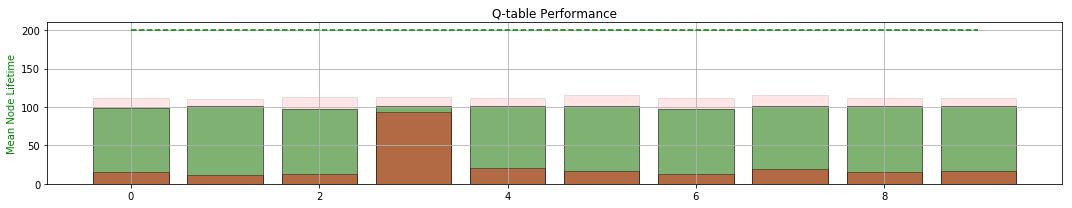

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 116.821	LOSS : 116.065	LOSS : 123.558	LOSS : 123.444	
Validating... MEAN TIME:  120.765
LOSS : 114.048	LOSS : 125.794	LOSS : 114.692	LOSS : 119.099	
Validating... MEAN TIME:  112.16
LOSS : 109.218	LOSS : 124.986	LOSS : 129.569	LOSS : 110.054	
Validating... MEAN TIME:  108.125
LOSS : 115.227	LOSS : 133.408	LOSS : 119.716	LOSS : 124.864	
Validating... MEAN TIME:  106.925
LOSS : 119.180	LOSS : 129.008	LOSS : 129.596	LOSS : 122.368	
Validating... MEAN TIME:  109.2
TRAINING TIME:0:00:45.603864


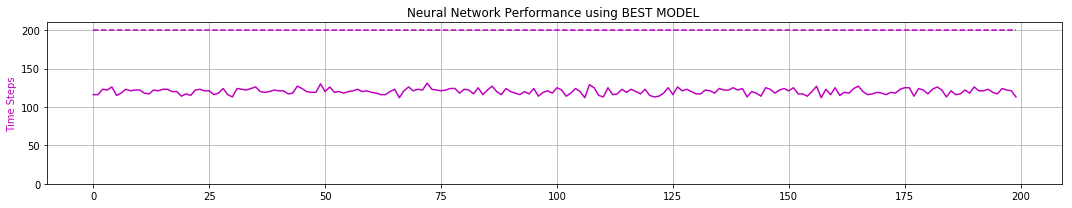

peak memory: 1435.83 MiB, increment: 978.16 MiB
0 -max- [ 0.197  0.828  0.050  0.815]
0 -min- [-2.400 -2.413 -0.208 -1.298]

1 -max- [ 0.192  0.828  0.049  0.900]
1 -min- [-2.398 -2.439 -0.203 -1.308]

2 -max- [ 0.185  1.214  0.053  0.750]
2 -min- [-2.399 -2.536 -0.209 -1.637]

3 -max- [ 0.186  0.829  0.049  0.726]
3 -min- [-2.400 -2.433 -0.206 -1.251]

4 -max- [ 0.194  0.989  0.050  0.874]
4 -min- [-2.398 -2.435 -0.200 -1.374]

5 -max- [ 0.199  0.994  0.050  0.898]
5 -min- [-2.400 -2.434 -0.202 -1.467]

6 -max- [ 0.222  0.831  0.050  0.832]
6 -min- [-2.400 -2.581 -0.208 -1.426]

7 -max- [ 0.198  0.980  0.054  0.913]
7 -min- [-2.399 -2.568 -0.207 -1.460]

8 -max- [ 0.182  0.828  0.053  0.878]
8 -min- [-2.399 -2.437 -0.205 -1.234]

9 -max- [ 0.184  0.830  0.050  0.826]
9 -min- [-2.398 -2.616 -0.205 -1.242]

Quantization TIME:  0.02 minutes


ITERATION # 33
TOTAL EXPERIENCE GENERATED:   89424
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   2294643
TOTAL PARALLEL TI

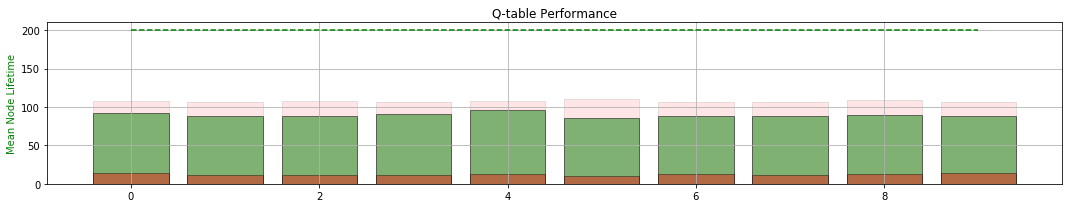

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 103.476	LOSS : 96.945	LOSS : 93.653	LOSS : 100.612	
Validating... MEAN TIME:  106.665
LOSS : 110.122	LOSS : 86.240	LOSS : 94.174	LOSS : 107.093	
Validating... MEAN TIME:  106.485
LOSS : 96.028	LOSS : 101.207	LOSS : 97.175	LOSS : 99.091	
Validating... MEAN TIME:  105.96
LOSS : 98.787	LOSS : 93.553	LOSS : 93.115	LOSS : 91.928	
Validating... MEAN TIME:  104.25
LOSS : 91.848	LOSS : 91.726	LOSS : 97.124	LOSS : 98.140	
Validating... MEAN TIME:  104.29
TRAINING TIME:0:00:43.854006


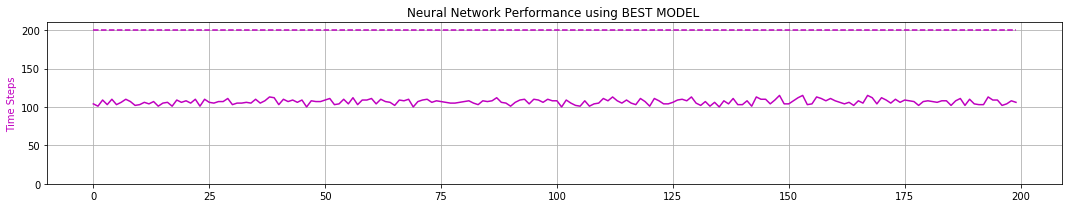

peak memory: 1470.49 MiB, increment: 1030.41 MiB
0 -max- [ 0.200  0.984  0.049  0.682]
0 -min- [-2.400 -2.746 -0.209 -1.433]

1 -max- [ 0.191  1.188  0.048  0.886]
1 -min- [-2.400 -2.897 -0.209 -1.659]

2 -max- [ 0.194  1.023  0.049  0.826]
2 -min- [-2.399 -2.738 -0.209 -1.416]

3 -max- [ 0.194  1.125  0.050  0.695]
3 -min- [-2.400 -2.799 -0.209 -1.652]

4 -max- [ 0.207  0.830  0.050  0.824]
4 -min- [-2.400 -2.903 -0.209 -1.378]

5 -max- [ 0.207  1.132  0.050  0.834]
5 -min- [-2.400 -2.711 -0.209 -1.872]

6 -max- [ 0.206  0.960  0.050  0.654]
6 -min- [-2.399 -2.750 -0.209 -1.375]

7 -max- [ 0.182  0.992  0.048  0.879]
7 -min- [-2.399 -2.615 -0.209 -1.473]

8 -max- [ 0.198  0.992  0.050  0.927]
8 -min- [-2.400 -2.804 -0.209 -1.420]

9 -max- [ 0.189  0.828  0.049  0.666]
9 -min- [-2.400 -2.894 -0.209 -1.295]

Quantization TIME:  0.02 minutes


ITERATION # 34
TOTAL EXPERIENCE GENERATED:   77938
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 103
TOTAL SERIAL TIMESTEPS:   2372581
TOTAL PARALLEL T

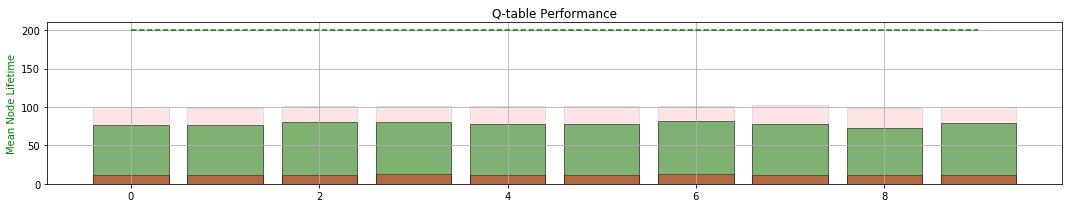

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 102.044	LOSS : 114.540	LOSS : 97.758	LOSS : 114.507	
Validating... MEAN TIME:  101.485
LOSS : 103.396	LOSS : 105.481	LOSS : 100.250	LOSS : 115.588	
Validating... MEAN TIME:  101.87
LOSS : 101.973	LOSS : 99.806	LOSS : 109.112	LOSS : 106.065	
Validating... MEAN TIME:  102.485
LOSS : 109.834	LOSS : 113.776	LOSS : 106.479	LOSS : 109.931	
Validating... MEAN TIME:  102.185
LOSS : 96.454	LOSS : 101.866	LOSS : 106.081	LOSS : 109.040	
Validating... MEAN TIME:  102.335
TRAINING TIME:0:00:43.425675


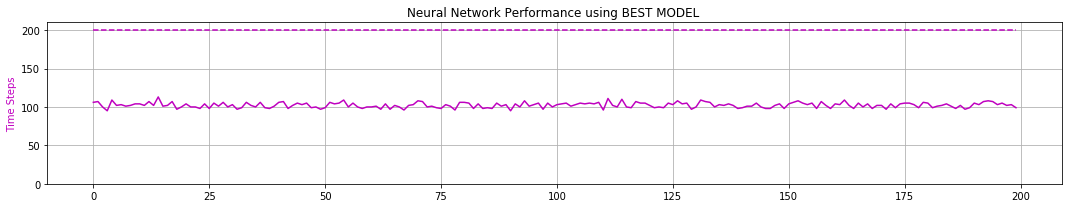

peak memory: 1459.10 MiB, increment: 1017.23 MiB
0 -max- [ 0.193  1.215  0.048  0.925]
0 -min- [-2.399 -3.317 -0.209 -1.669]

1 -max- [ 0.194  1.218  0.049  0.647]
1 -min- [-2.399 -3.299 -0.209 -1.675]

2 -max- [ 0.197  1.184  0.060  0.613]
2 -min- [-2.400 -3.169 -0.209 -1.680]

3 -max- [ 0.207  1.206  0.050  0.839]
3 -min- [-2.400 -3.260 -0.209 -1.679]

4 -max- [ 0.215  1.017  0.050  0.833]
4 -min- [-2.400 -3.343 -0.209 -1.493]

5 -max- [ 0.208  1.211  0.050  0.678]
5 -min- [-2.400 -3.336 -0.209 -1.678]

6 -max- [ 0.190  1.177  0.048  0.816]
6 -min- [-2.400 -3.345 -0.209 -1.661]

7 -max- [ 0.198  1.200  0.050  0.639]
7 -min- [-2.400 -3.341 -0.209 -1.675]

8 -max- [ 0.191  1.143  0.049  0.657]
8 -min- [-2.400 -3.259 -0.209 -1.677]

9 -max- [ 0.196  1.216  0.050  0.654]
9 -min- [-2.400 -3.306 -0.209 -1.676]

Quantization TIME:  0.01 minutes


ITERATION # 35
TOTAL EXPERIENCE GENERATED:   65574
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 101
TOTAL SERIAL TIMESTEPS:   2438155
TOTAL PARALLEL T

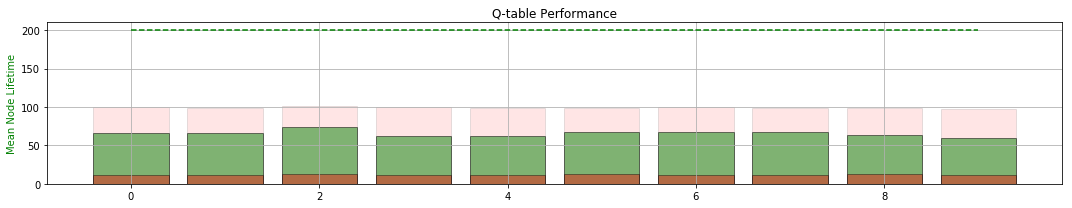

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 122.123	LOSS : 118.342	LOSS : 114.292	LOSS : 133.128	
Validating... MEAN TIME:  102.13
LOSS : 130.207	LOSS : 113.920	LOSS : 117.662	LOSS : 122.386	
Validating... MEAN TIME:  103.56
LOSS : 112.343	LOSS : 108.361	LOSS : 122.872	LOSS : 113.520	
Validating... MEAN TIME:  105.85
LOSS : 116.667	LOSS : 118.724	LOSS : 123.783	LOSS : 126.471	
Validating... MEAN TIME:  109.87
LOSS : 127.581	LOSS : 119.229	LOSS : 116.372	LOSS : 127.528	
Validating... MEAN TIME:  109.915
TRAINING TIME:0:00:43.800450


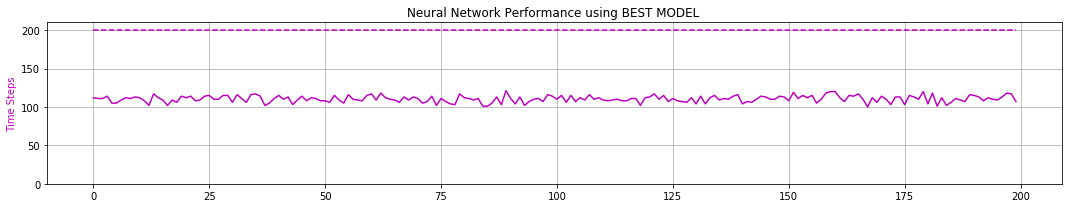

peak memory: 1459.10 MiB, increment: 978.29 MiB
0 -max- [ 0.182  1.217  0.049  0.757]
0 -min- [-2.400 -3.475 -0.209 -1.640]

1 -max- [ 0.194  1.125  0.050  0.832]
1 -min- [-2.400 -3.486 -0.209 -1.652]

2 -max- [ 0.194  0.832  0.050  0.699]
2 -min- [-2.398 -3.464 -0.209 -1.307]

3 -max- [ 0.215  1.000  0.051  0.824]
3 -min- [-2.399 -3.478 -0.209 -1.482]

4 -max- [ 0.198  1.139  0.050  0.663]
4 -min- [-2.399 -3.484 -0.209 -1.656]

5 -max- [ 0.196  0.982  0.048  0.680]
5 -min- [-2.399 -3.478 -0.209 -1.441]

6 -max- [ 0.188  1.012  0.050  0.736]
6 -min- [-2.399 -3.478 -0.209 -1.385]

7 -max- [ 0.183  0.832  0.049  0.673]
7 -min- [-2.399 -3.496 -0.209 -1.247]

8 -max- [ 0.202  1.208  0.050  0.680]
8 -min- [-2.399 -3.482 -0.209 -1.660]

9 -max- [ 0.178  1.021  0.049  0.689]
9 -min- [-2.399 -3.509 -0.209 -1.456]

Quantization TIME:  0.01 minutes


ITERATION # 36
TOTAL EXPERIENCE GENERATED:   65749
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 85
TOTAL SERIAL TIMESTEPS:   2503904
TOTAL PARALLEL TIM

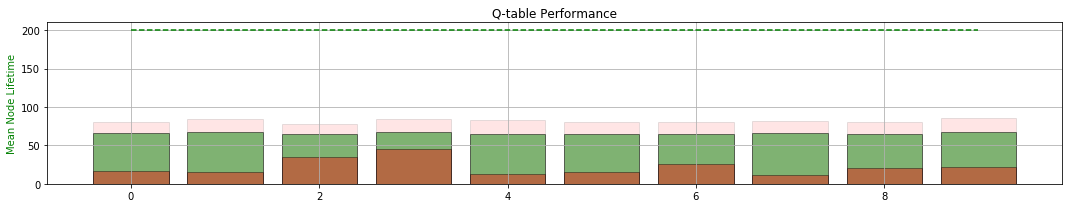

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 121.570	LOSS : 128.842	LOSS : 135.690	LOSS : 133.309	
Validating... MEAN TIME:  109.815
LOSS : 130.549	LOSS : 126.854	LOSS : 133.337	LOSS : 129.936	
Validating... MEAN TIME:  113.94
LOSS : 138.032	LOSS : 129.341	LOSS : 121.983	LOSS : 136.197	
Validating... MEAN TIME:  120.97
LOSS : 129.247	LOSS : 126.386	LOSS : 136.356	LOSS : 122.898	
Validating... MEAN TIME:  129.125
LOSS : 142.822	LOSS : 131.099	LOSS : 129.022	LOSS : 119.487	
Validating... MEAN TIME:  134.655
TRAINING TIME:0:00:47.237209


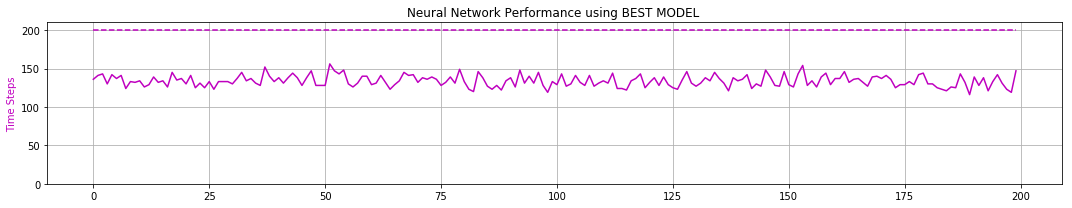

peak memory: 1455.62 MiB, increment: 1036.77 MiB
0 -max- [ 0.178  0.989  0.050  0.576]
0 -min- [-1.379 -2.398 -0.209 -1.374]

1 -max- [ 0.178  1.002  0.050  0.597]
1 -min- [-1.312 -2.372 -0.209 -1.455]

2 -max- [ 0.199  1.014  0.050  0.697]
2 -min- [-1.203 -2.232 -0.209 -1.422]

3 -max- [ 0.190  1.019  0.050  0.604]
3 -min- [-1.297 -2.395 -0.209 -1.409]

4 -max- [ 0.165  0.828  0.048  0.831]
4 -min- [-1.398 -2.397 -0.209 -1.338]

5 -max- [ 0.169  1.024  0.050  0.630]
5 -min- [-1.315 -2.427 -0.209 -1.494]

6 -max- [ 0.167  0.827  0.049  0.592]
6 -min- [-1.299 -2.386 -0.209 -1.237]

7 -max- [ 0.186  1.013  0.050  0.610]
7 -min- [-1.280 -2.381 -0.209 -1.378]

8 -max- [ 0.154  0.829  0.049  0.579]
8 -min- [-1.256 -2.371 -0.209 -1.194]

9 -max- [ 0.189  0.976  0.049  0.571]
9 -min- [-1.375 -2.390 -0.209 -1.373]

Quantization TIME:  0.01 minutes


ITERATION # 37
TOTAL EXPERIENCE GENERATED:   92340
SMALLEST TIMESTEP: 53
LARGEST  TIMESTEP: 114
TOTAL SERIAL TIMESTEPS:   2596244
TOTAL PARALLEL T

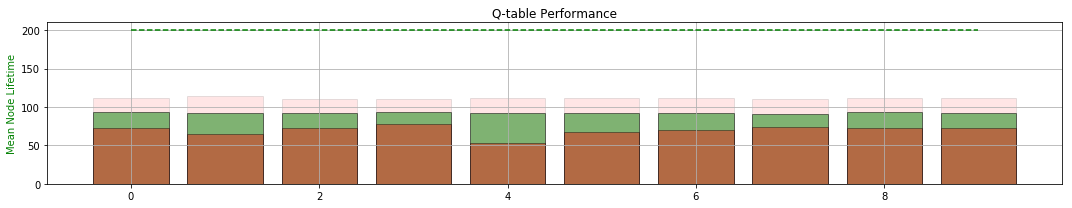

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 119.815	LOSS : 115.941	LOSS : 123.531	LOSS : 125.356	
Validating... MEAN TIME:  120.14
LOSS : 117.995	LOSS : 119.144	LOSS : 118.981	LOSS : 120.322	
Validating... MEAN TIME:  116.68
LOSS : 116.209	LOSS : 117.428	LOSS : 115.576	LOSS : 123.831	
Validating... MEAN TIME:  114.18
LOSS : 123.973	LOSS : 120.795	LOSS : 127.227	LOSS : 123.556	
Validating... MEAN TIME:  115.14
LOSS : 130.592	LOSS : 129.923	LOSS : 125.487	LOSS : 117.735	
Validating... MEAN TIME:  116.465
TRAINING TIME:0:00:46.561901


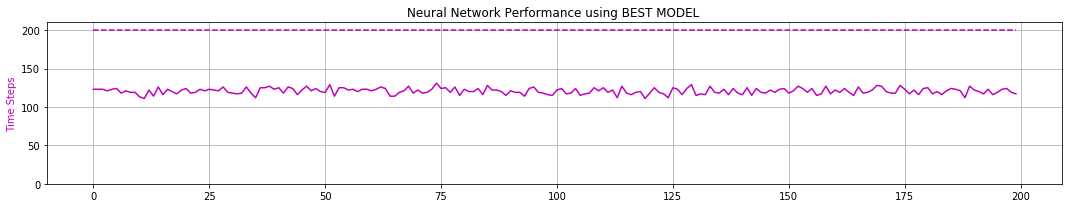

peak memory: 1489.67 MiB, increment: 1012.35 MiB
0 -max- [ 0.178  0.819  0.050  0.649]
0 -min- [-2.371 -3.128 -0.209 -1.156]

1 -max- [ 0.191  0.827  0.050  0.921]
1 -min- [-2.391 -3.108 -0.209 -1.298]

2 -max- [ 0.183  0.944  0.050  0.617]
2 -min- [-2.399 -3.152 -0.209 -1.361]

3 -max- [ 0.167  0.820  0.048  0.700]
3 -min- [-2.394 -3.147 -0.209 -1.255]

4 -max- [ 0.169  1.019  0.050  0.725]
4 -min- [-2.395 -3.132 -0.209 -1.389]

5 -max- [ 0.161  0.828  0.049  0.986]
5 -min- [-2.397 -3.138 -0.209 -1.206]

6 -max- [ 0.172  1.013  0.050  0.692]
6 -min- [-2.396 -3.137 -0.209 -1.364]

7 -max- [ 0.143  0.828  0.049  0.686]
7 -min- [-2.395 -3.134 -0.209 -1.214]

8 -max- [ 0.186  0.976  0.049  0.661]
8 -min- [-2.388 -3.126 -0.209 -1.373]

9 -max- [ 0.187  0.821  0.051  0.750]
9 -min- [-2.396 -3.098 -0.209 -1.161]

Quantization TIME:  0.02 minutes


ITERATION # 38
TOTAL EXPERIENCE GENERATED:   93870
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 109
TOTAL SERIAL TIMESTEPS:   2690114
TOTAL PARALLEL T

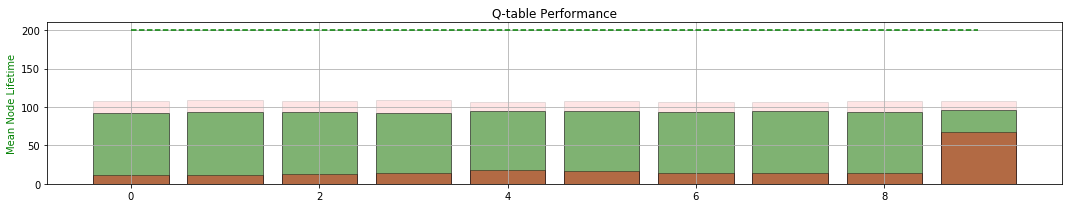

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 106.111	LOSS : 102.271	LOSS : 100.977	LOSS : 97.294	
Validating... MEAN TIME:  109.735
LOSS : 102.323	LOSS : 98.564	LOSS : 99.580	LOSS : 96.051	
Validating... MEAN TIME:  106.655
LOSS : 104.301	LOSS : 108.208	LOSS : 96.114	LOSS : 98.036	
Validating... MEAN TIME:  106.74
LOSS : 96.474	LOSS : 100.123	LOSS : 106.500	LOSS : 103.004	
Validating... MEAN TIME:  106.965
LOSS : 96.569	LOSS : 92.866	LOSS : 94.414	LOSS : 103.758	
Validating... MEAN TIME:  106.655
TRAINING TIME:0:00:43.906756


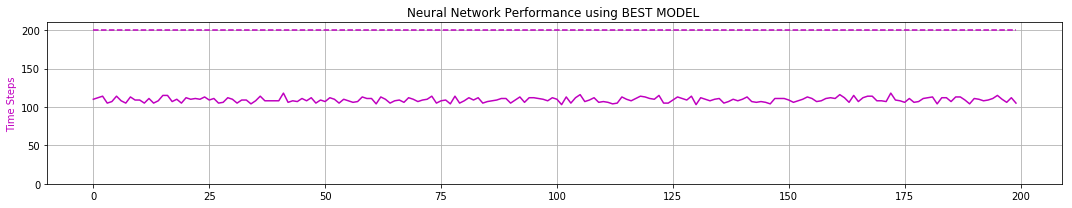

peak memory: 1455.75 MiB, increment: 1017.24 MiB
0 -max- [ 0.199  1.003  0.050  0.813]
0 -min- [-2.398 -3.151 -0.209 -1.446]

1 -max- [ 0.201  1.206  0.050  0.757]
1 -min- [-2.398 -3.156 -0.209 -1.681]

2 -max- [ 0.178  1.177  0.048  0.752]
2 -min- [-2.400 -3.157 -0.209 -1.661]

3 -max- [ 0.177  0.982  0.050  0.828]
3 -min- [-2.400 -3.154 -0.209 -1.425]

4 -max- [ 0.175  0.966  0.049  0.678]
4 -min- [-2.399 -3.157 -0.209 -1.430]

5 -max- [ 0.188  1.208  0.050  0.881]
5 -min- [-2.398 -3.156 -0.209 -1.724]

6 -max- [ 0.156  0.829  0.052  0.743]
6 -min- [-2.399 -3.147 -0.209 -1.241]

7 -max- [ 0.197  1.171  0.049  0.667]
7 -min- [-2.399 -3.153 -0.209 -1.656]

8 -max- [ 0.195  1.178  0.047  0.671]
8 -min- [-2.400 -3.158 -0.209 -1.659]

9 -max- [ 0.200  1.209  0.051  0.659]
9 -min- [-2.400 -3.157 -0.209 -1.658]

Quantization TIME:  0.01 minutes


ITERATION # 39
TOTAL EXPERIENCE GENERATED:   41207
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 103
TOTAL SERIAL TIMESTEPS:   2731321
TOTAL PARALLEL T

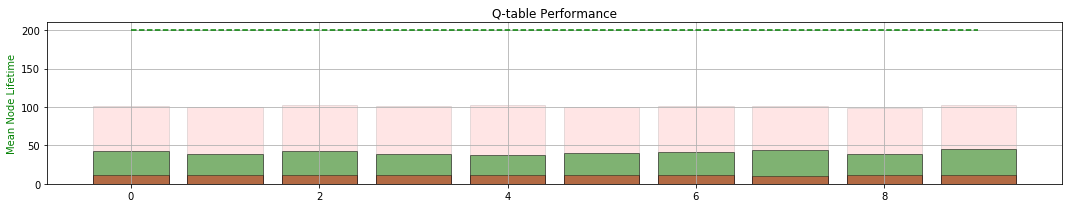

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 119.384	LOSS : 128.254	LOSS : 130.002	LOSS : 119.653	
Validating... MEAN TIME:  106.385
LOSS : 117.274	LOSS : 129.823	LOSS : 119.698	LOSS : 114.317	
Validating... MEAN TIME:  107.89
LOSS : 134.564	LOSS : 106.898	LOSS : 120.073	LOSS : 125.166	
Validating... MEAN TIME:  109.875
LOSS : 126.836	LOSS : 122.097	LOSS : 118.702	LOSS : 121.190	
Validating... MEAN TIME:  109.94
LOSS : 128.904	LOSS : 122.199	LOSS : 123.463	LOSS : 128.051	
Validating... MEAN TIME:  111.015
TRAINING TIME:0:00:44.940995


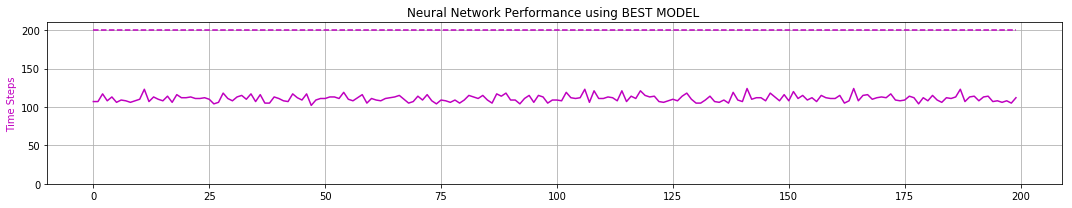

peak memory: 1419.04 MiB, increment: 1035.48 MiB
0 -max- [ 0.216  1.211  0.050  0.615]
0 -min- [-2.398 -2.958 -0.209 -1.722]

1 -max- [ 0.196  1.178  0.048  0.625]
1 -min- [-2.400 -2.974 -0.209 -1.693]

2 -max- [ 0.200  1.138  0.050  0.677]
2 -min- [-2.400 -2.965 -0.209 -1.675]

3 -max- [ 0.195  1.156  0.049  0.668]
3 -min- [-2.398 -2.961 -0.209 -1.678]

4 -max- [ 0.204  1.216  0.050  0.632]
4 -min- [-2.399 -2.969 -0.209 -1.692]

5 -max- [ 0.172  1.159  0.049  0.667]
5 -min- [-2.399 -3.097 -0.209 -1.681]

6 -max- [ 0.224  1.172  0.049  0.639]
6 -min- [-2.394 -2.946 -0.209 -1.695]

7 -max- [ 0.218  1.194  0.047  0.849]
7 -min- [-2.399 -3.084 -0.209 -1.695]

8 -max- [ 0.217  1.210  0.059  0.646]
8 -min- [-2.399 -2.972 -0.209 -1.697]

9 -max- [ 0.200  1.150  0.047  0.654]
9 -min- [-2.400 -2.974 -0.209 -1.732]

Quantization TIME:  0.02 minutes


ITERATION # 40
TOTAL EXPERIENCE GENERATED:   95333
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   2826654
TOTAL PARALLEL T

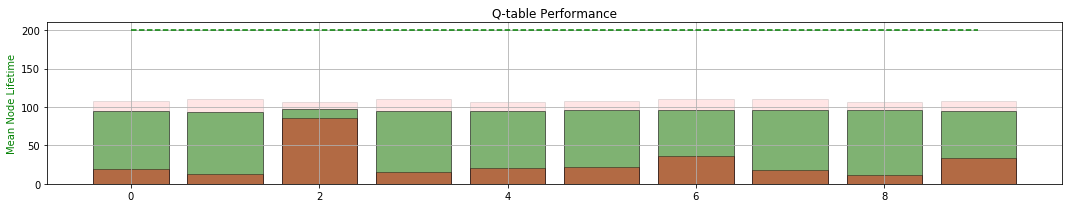

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 118.732	LOSS : 124.523	LOSS : 114.616	LOSS : 111.352	
Validating... MEAN TIME:  107.265
LOSS : 114.228	LOSS : 120.252	LOSS : 119.415	LOSS : 118.149	
Validating... MEAN TIME:  105.04
LOSS : 114.763	LOSS : 112.102	LOSS : 117.158	LOSS : 124.158	
Validating... MEAN TIME:  104.695
LOSS : 117.058	LOSS : 117.038	LOSS : 113.174	LOSS : 114.630	
Validating... MEAN TIME:  104.51
LOSS : 120.991	LOSS : 120.954	LOSS : 117.554	LOSS : 119.306	
Validating... MEAN TIME:  106.655
TRAINING TIME:0:00:43.997509


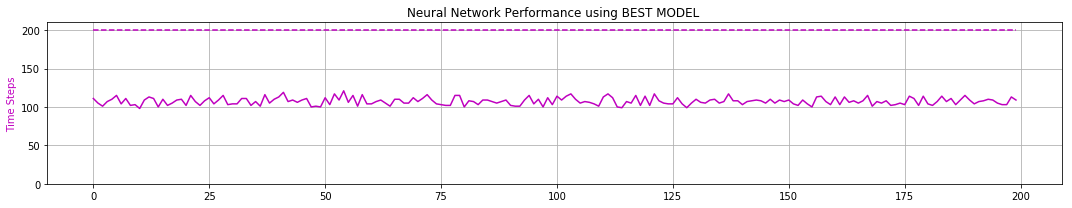

peak memory: 1474.41 MiB, increment: 1032.14 MiB
0 -max- [ 0.158  0.960  0.048  0.792]
0 -min- [-2.398 -3.146 -0.209 -1.439]

1 -max- [ 0.161  0.972  0.050  0.643]
1 -min- [-2.400 -2.966 -0.209 -1.448]

2 -max- [ 0.159  0.973  0.049  0.611]
2 -min- [-2.399 -3.146 -0.209 -1.407]

3 -max- [ 0.164  1.013  0.050  0.619]
3 -min- [-2.399 -2.969 -0.209 -1.417]

4 -max- [ 0.140  0.829  0.049  0.610]
4 -min- [-2.396 -3.141 -0.209 -1.219]

5 -max- [ 0.170  0.976  0.049  0.522]
5 -min- [-2.399 -2.966 -0.209 -1.362]

6 -max- [ 0.179  0.826  0.047  0.799]
6 -min- [-2.399 -3.146 -0.209 -1.285]

7 -max- [ 0.180  0.951  0.051  0.743]
7 -min- [-2.399 -3.154 -0.209 -1.398]

8 -max- [ 0.173  0.830  0.047  0.699]
8 -min- [-2.400 -3.160 -0.209 -1.347]

9 -max- [ 0.164  1.023  0.050  0.596]
9 -min- [-2.400 -2.967 -0.209 -1.381]

Quantization TIME:  0.02 minutes


ITERATION # 41
TOTAL EXPERIENCE GENERATED:   86888
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 108
TOTAL SERIAL TIMESTEPS:   2913542
TOTAL PARALLEL T

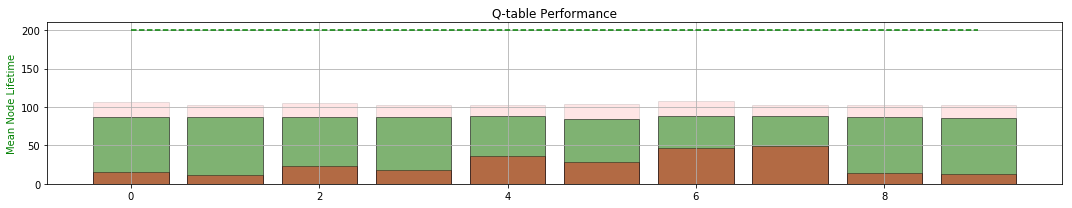

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 96.322	LOSS : 115.852	LOSS : 101.503	LOSS : 102.989	
Validating... MEAN TIME:  100.98
LOSS : 104.456	LOSS : 106.770	LOSS : 105.630	LOSS : 109.059	
Validating... MEAN TIME:  101.165
LOSS : 111.778	LOSS : 105.355	LOSS : 106.190	LOSS : 107.010	
Validating... MEAN TIME:  100.03
LOSS : 109.681	LOSS : 107.787	LOSS : 102.925	LOSS : 102.919	
Validating... MEAN TIME:  100.62
LOSS : 104.859	LOSS : 106.099	LOSS : 111.647	LOSS : 111.551	
Validating... MEAN TIME:  100.67
TRAINING TIME:0:00:43.279243


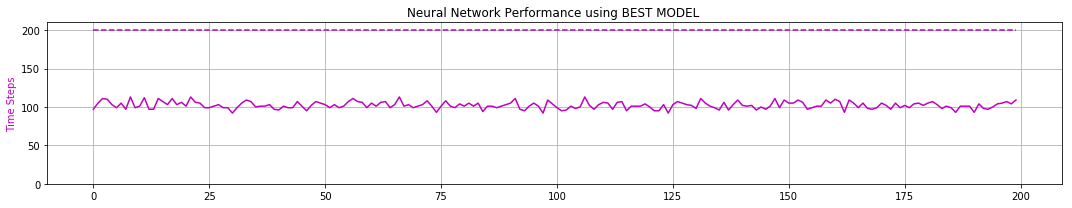

peak memory: 1435.48 MiB, increment: 1035.24 MiB
0 -max- [ 0.174  0.972  0.050  0.653]
0 -min- [-2.361 -3.052 -0.209 -1.448]

1 -max- [ 0.159  0.828  0.049  0.627]
1 -min- [-2.320 -3.081 -0.209 -1.320]

2 -max- [ 0.164  1.011  0.052  0.585]
2 -min- [-2.368 -3.043 -0.209 -1.400]

3 -max- [ 0.144  0.995  0.056  0.619]
3 -min- [-2.377 -3.119 -0.209 -1.459]

4 -max- [ 0.170  0.976  0.049  0.609]
4 -min- [-2.357 -2.934 -0.209 -1.362]

5 -max- [ 0.179  0.823  0.047  0.775]
5 -min- [-2.389 -3.110 -0.209 -1.217]

6 -max- [ 0.175  1.014  0.051  0.637]
6 -min- [-2.400 -3.110 -0.209 -1.371]

7 -max- [ 0.165  1.025  0.047  0.610]
7 -min- [-2.375 -3.085 -0.209 -1.476]

8 -max- [ 0.180  1.177  0.050  0.600]
8 -min- [-2.377 -2.931 -0.209 -1.692]

9 -max- [ 0.147  0.964  0.050  0.629]
9 -min- [-2.350 -2.943 -0.209 -1.368]

Quantization TIME:  0.01 minutes


ITERATION # 42
TOTAL EXPERIENCE GENERATED:   59750
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 99
TOTAL SERIAL TIMESTEPS:   2973292
TOTAL PARALLEL TI

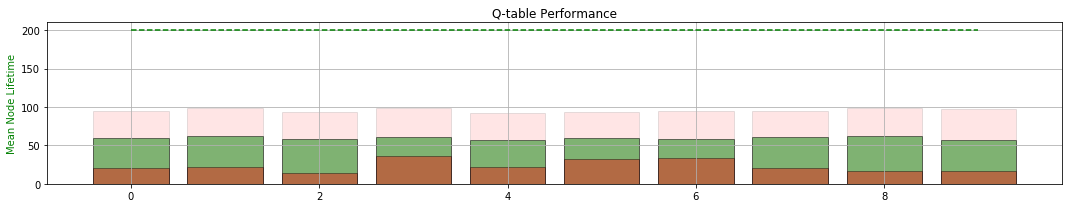

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 104.866	LOSS : 105.607	LOSS : 115.597	LOSS : 112.763	
Validating... MEAN TIME:  103.15
LOSS : 118.302	LOSS : 121.690	LOSS : 112.713	LOSS : 117.435	
Validating... MEAN TIME:  105.385
LOSS : 111.889	LOSS : 117.361	LOSS : 110.708	LOSS : 107.029	
Validating... MEAN TIME:  106.235
LOSS : 114.626	LOSS : 112.343	LOSS : 116.971	LOSS : 106.238	
Validating... MEAN TIME:  107.82
LOSS : 108.946	LOSS : 110.917	LOSS : 114.446	LOSS : 102.915	
Validating... MEAN TIME:  108.33
TRAINING TIME:0:00:44.483386


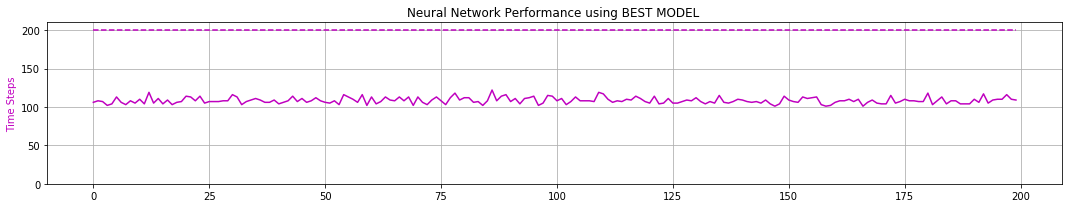

peak memory: 1447.70 MiB, increment: 989.91 MiB
0 -max- [ 0.143  0.829  0.049  0.593]
0 -min- [-1.977 -2.950 -0.209 -1.244]

1 -max- [ 0.157  1.013  0.050  0.624]
1 -min- [-2.008 -2.951 -0.209 -1.407]

2 -max- [ 0.126  0.829  0.049  0.597]
2 -min- [-1.971 -2.933 -0.209 -1.359]

3 -max- [ 0.162  0.976  0.054  0.611]
3 -min- [-2.025 -2.922 -0.209 -1.362]

4 -max- [ 0.164  0.964  0.047  0.578]
4 -min- [-1.986 -2.941 -0.209 -1.437]

5 -max- [ 0.179  1.014  0.051  0.826]
5 -min- [-1.735 -2.761 -0.209 -1.373]

6 -max- [ 0.157  0.830  0.047  0.552]
6 -min- [-1.915 -2.925 -0.209 -1.229]

7 -max- [ 0.157  1.023  0.050  0.615]
7 -min- [-2.013 -2.928 -0.209 -1.408]

8 -max- [ 0.140  1.019  0.050  0.519]
8 -min- [-2.024 -2.941 -0.209 -1.395]

9 -max- [ 0.139  0.828  0.050  0.612]
9 -min- [-2.025 -2.930 -0.209 -1.250]

Quantization TIME:  0.01 minutes


ITERATION # 43
TOTAL EXPERIENCE GENERATED:   86529
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 107
TOTAL SERIAL TIMESTEPS:   3059821
TOTAL PARALLEL TI

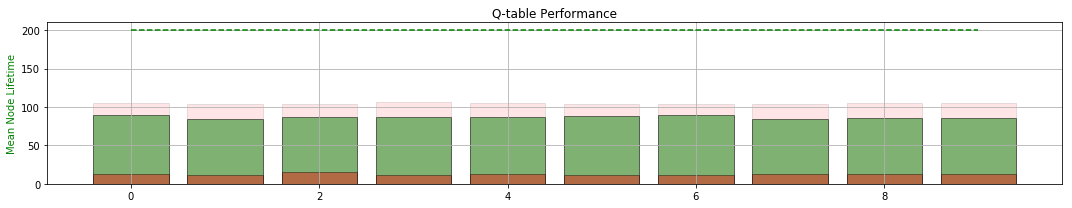

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 122.639	LOSS : 115.157	LOSS : 120.149	LOSS : 121.954	
Validating... MEAN TIME:  111.395
LOSS : 124.259	LOSS : 116.175	LOSS : 116.393	LOSS : 120.169	
Validating... MEAN TIME:  112.65
LOSS : 120.736	LOSS : 114.718	LOSS : 122.779	LOSS : 121.597	
Validating... MEAN TIME:  115.48
LOSS : 116.720	LOSS : 111.921	LOSS : 119.216	LOSS : 124.766	
Validating... MEAN TIME:  115.93
LOSS : 119.907	LOSS : 117.926	LOSS : 118.686	LOSS : 113.948	
Validating... MEAN TIME:  118.6
TRAINING TIME:0:00:47.291293


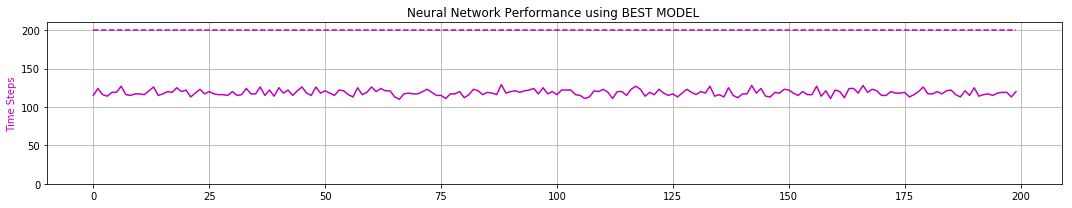

peak memory: 1465.98 MiB, increment: 1031.88 MiB
0 -max- [ 0.180  1.208  0.050  0.626]
0 -min- [-2.399 -2.969 -0.209 -1.660]

1 -max- [ 0.154  0.975  0.049  0.604]
1 -min- [-2.400 -3.129 -0.209 -1.450]

2 -max- [ 0.189  1.171  0.049  0.632]
2 -min- [-2.398 -2.966 -0.209 -1.656]

3 -max- [ 0.187  1.187  0.047  0.758]
3 -min- [-2.400 -3.110 -0.209 -1.669]

4 -max- [ 0.192  1.146  0.051  0.689]
4 -min- [-2.399 -2.973 -0.209 -1.658]

5 -max- [ 0.181  1.140  0.052  0.627]
5 -min- [-2.400 -3.125 -0.209 -1.667]

6 -max- [ 0.188  1.217  0.050  0.615]
6 -min- [-2.400 -2.970 -0.209 -1.662]

7 -max- [ 0.163  1.159  0.050  0.634]
7 -min- [-2.400 -2.967 -0.209 -1.651]

8 -max- [ 0.171  0.950  0.050  0.632]
8 -min- [-2.399 -3.106 -0.209 -1.466]

9 -max- [ 0.185  1.199  0.049  0.844]
9 -min- [-2.400 -2.971 -0.209 -1.659]

Quantization TIME:  0.02 minutes


ITERATION # 44
TOTAL EXPERIENCE GENERATED:   88188
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   3148009
TOTAL PARALLEL T

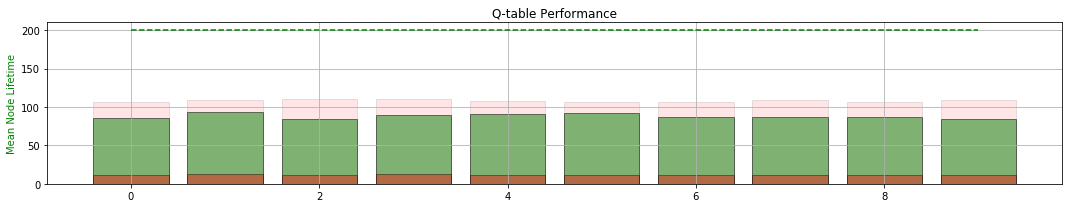

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 108.900	LOSS : 114.964	LOSS : 111.230	LOSS : 111.593	
Validating... MEAN TIME:  107.185
LOSS : 114.368	LOSS : 118.394	LOSS : 116.076	LOSS : 106.828	
Validating... MEAN TIME:  102.09
LOSS : 118.149	LOSS : 104.808	LOSS : 110.627	LOSS : 108.019	
Validating... MEAN TIME:  100.245
LOSS : 107.524	LOSS : 108.423	LOSS : 110.829	LOSS : 110.981	
Validating... MEAN TIME:  100.96
LOSS : 115.537	LOSS : 108.810	LOSS : 114.180	LOSS : 112.349	
Validating... MEAN TIME:  101.47
TRAINING TIME:0:00:44.774894


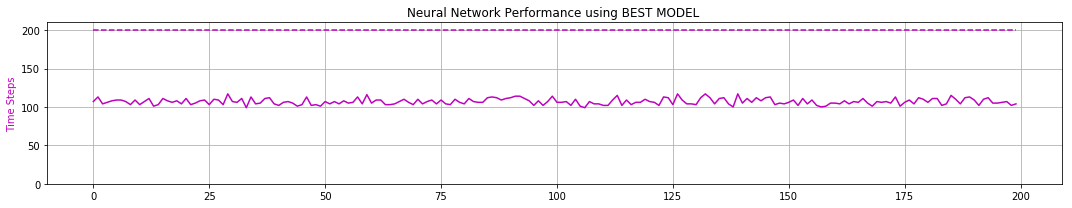

peak memory: 1438.28 MiB, increment: 1035.54 MiB
0 -max- [ 0.164  1.020  0.049  0.665]
0 -min- [-2.400 -2.599 -0.209 -1.525]

1 -max- [ 0.197  1.171  0.049  0.646]
1 -min- [-2.400 -2.699 -0.209 -1.668]

2 -max- [ 0.203  1.156  0.047  0.694]
2 -min- [-2.399 -2.621 -0.209 -1.715]

3 -max- [ 0.200  1.209  0.051  0.932]
3 -min- [-2.399 -2.793 -0.209 -1.664]

4 -max- [ 0.197  1.142  0.047  0.696]
4 -min- [-2.398 -2.738 -0.209 -1.710]

5 -max- [ 0.196  1.217  0.050  0.675]
5 -min- [-2.400 -2.620 -0.209 -1.677]

6 -max- [ 0.183  1.200  0.050  0.688]
6 -min- [-2.400 -2.726 -0.208 -1.676]

7 -max- [ 0.179  1.168  0.050  0.702]
7 -min- [-2.399 -2.808 -0.209 -1.675]

8 -max- [ 0.195  1.218  0.049  0.662]
8 -min- [-2.399 -2.615 -0.209 -1.675]

9 -max- [ 0.207  1.215  0.050  0.784]
9 -min- [-2.400 -2.614 -0.209 -1.705]

Quantization TIME:  0.02 minutes


ITERATION # 45
TOTAL EXPERIENCE GENERATED:   76641
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 104
TOTAL SERIAL TIMESTEPS:   3224650
TOTAL PARALLEL T

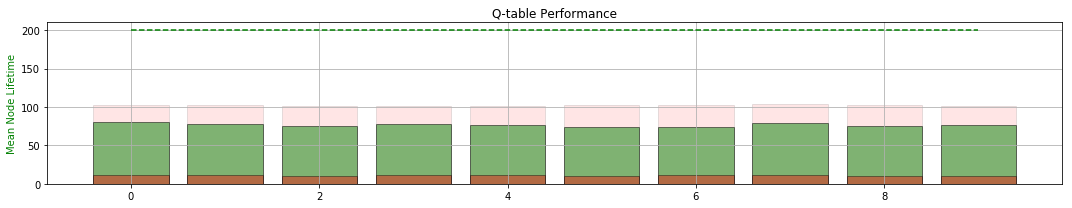

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 100.179	LOSS : 115.019	LOSS : 104.866	LOSS : 95.666	
Validating... MEAN TIME:  99.07
LOSS : 109.291	LOSS : 107.481	LOSS : 111.747	LOSS : 113.681	
Validating... MEAN TIME:  99.405
LOSS : 112.877	LOSS : 106.785	LOSS : 109.712	LOSS : 104.950	
Validating... MEAN TIME:  100.22
LOSS : 108.069	LOSS : 103.354	LOSS : 99.923	LOSS : 106.616	
Validating... MEAN TIME:  99.045
LOSS : 104.595	LOSS : 105.554	LOSS : 105.963	LOSS : 95.756	
Validating... MEAN TIME:  99.215
TRAINING TIME:0:00:43.211567


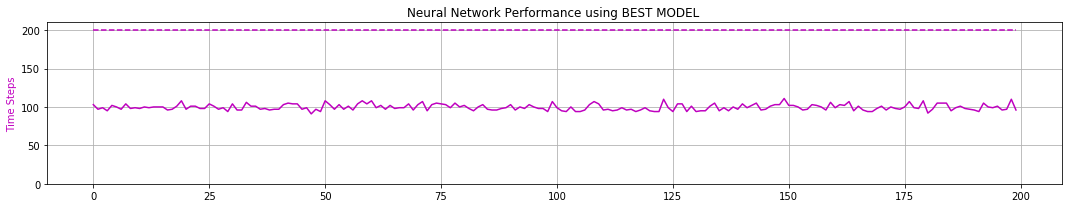

peak memory: 1458.18 MiB, increment: 996.84 MiB
0 -max- [ 0.197  1.171  0.049  0.691]
0 -min- [-2.400 -2.957 -0.209 -1.664]

1 -max- [ 0.203  1.203  0.052  0.793]
1 -min- [-2.400 -3.158 -0.209 -1.678]

2 -max- [ 0.200  1.209  0.051  0.694]
2 -min- [-2.398 -2.942 -0.209 -1.664]

3 -max- [ 0.191  1.137  0.047  0.790]
3 -min- [-2.399 -2.987 -0.209 -1.675]

4 -max- [ 0.196  1.218  0.050  0.773]
4 -min- [-2.400 -2.971 -0.209 -1.683]

5 -max- [ 0.179  1.200  0.050  0.668]
5 -min- [-2.400 -2.969 -0.209 -1.714]

6 -max- [ 0.182  1.209  0.054  0.658]
6 -min- [-2.400 -2.933 -0.209 -1.679]

7 -max- [ 0.207  1.199  0.049  0.685]
7 -min- [-2.399 -2.962 -0.209 -1.675]

8 -max- [ 0.207  1.218  0.050  0.691]
8 -min- [-2.400 -2.952 -0.209 -1.679]

9 -max- [ 0.198  1.173  0.050  0.630]
9 -min- [-2.400 -2.974 -0.209 -1.670]

Quantization TIME:  0.01 minutes


ITERATION # 46
TOTAL EXPERIENCE GENERATED:   47027
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 103
TOTAL SERIAL TIMESTEPS:   3271677
TOTAL PARALLEL TI

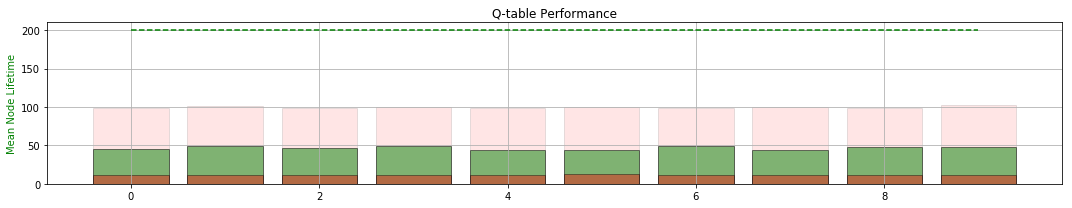

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 115.865	LOSS : 123.684	LOSS : 124.233	LOSS : 119.021	
Validating... MEAN TIME:  101.635
LOSS : 128.768	LOSS : 127.144	LOSS : 122.682	LOSS : 122.349	
Validating... MEAN TIME:  104.985
LOSS : 129.110	LOSS : 134.155	LOSS : 129.923	LOSS : 127.070	
Validating... MEAN TIME:  107.575
LOSS : 125.340	LOSS : 130.114	LOSS : 132.105	LOSS : 125.928	
Validating... MEAN TIME:  110.9
LOSS : 123.241	LOSS : 127.540	LOSS : 129.009	LOSS : 130.153	
Validating... MEAN TIME:  111.02
TRAINING TIME:0:00:44.079985


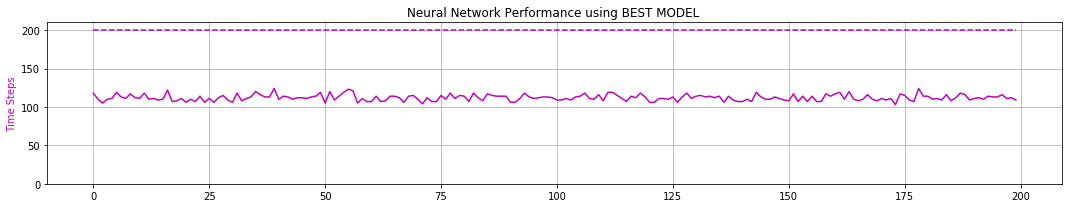

peak memory: 1458.31 MiB, increment: 1016.50 MiB
0 -max- [ 0.203  1.124  0.047  0.767]
0 -min- [-2.398 -3.347 -0.209 -1.668]

1 -max- [ 0.192  1.166  0.051  0.621]
1 -min- [-2.400 -3.293 -0.209 -1.664]

2 -max- [ 0.186  1.137  0.047  0.635]
2 -min- [-2.399 -3.322 -0.209 -1.675]

3 -max- [ 0.188  1.217  0.050  0.579]
3 -min- [-2.398 -3.124 -0.209 -1.718]

4 -max- [ 0.167  1.200  0.050  0.580]
4 -min- [-2.396 -3.136 -0.209 -1.676]

5 -max- [ 0.179  1.168  0.057  0.629]
5 -min- [-2.397 -3.306 -0.209 -1.673]

6 -max- [ 0.195  1.218  0.049  0.748]
6 -min- [-2.400 -3.465 -0.209 -1.675]

7 -max- [ 0.197  1.213  0.050  0.606]
7 -min- [-2.393 -3.271 -0.209 -1.669]

8 -max- [ 0.184  1.173  0.050  0.630]
8 -min- [-2.398 -3.314 -0.209 -1.660]

9 -max- [ 0.217  1.198  0.051  0.853]
9 -min- [-2.398 -3.302 -0.209 -1.664]

Quantization TIME:  0.02 minutes


ITERATION # 47
TOTAL EXPERIENCE GENERATED:   94912
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   3366589
TOTAL PARALLEL T

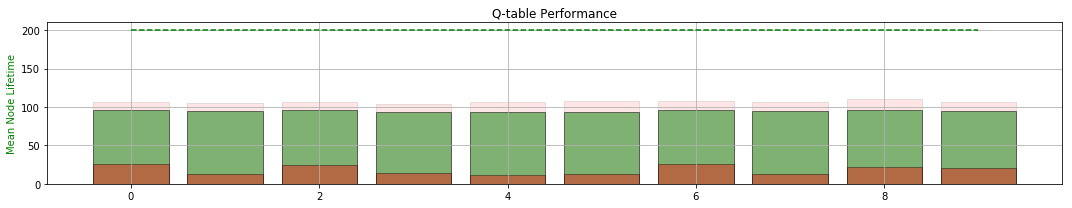

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 123.284	LOSS : 123.006	LOSS : 128.452	LOSS : 123.052	
Validating... MEAN TIME:  108.33
LOSS : 128.687	LOSS : 123.805	LOSS : 116.497	LOSS : 126.433	
Validating... MEAN TIME:  106.595
LOSS : 115.396	LOSS : 114.344	LOSS : 115.878	LOSS : 124.901	
Validating... MEAN TIME:  107.655
LOSS : 122.410	LOSS : 122.488	LOSS : 116.833	LOSS : 123.688	
Validating... MEAN TIME:  106.305
LOSS : 124.617	LOSS : 123.135	LOSS : 126.767	LOSS : 123.776	
Validating... MEAN TIME:  105.815
TRAINING TIME:0:00:45.098704


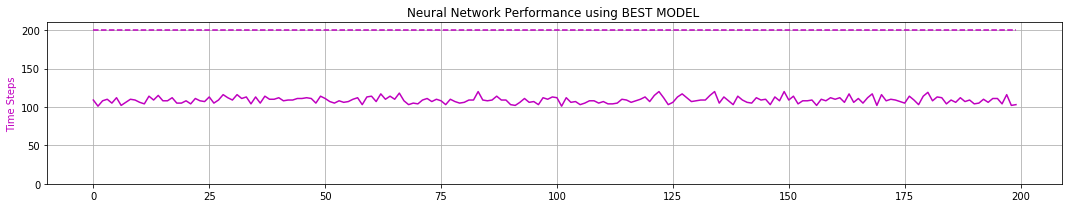

peak memory: 1445.56 MiB, increment: 1018.33 MiB
0 -max- [ 0.192  1.146  0.051  0.669]
0 -min- [-2.400 -3.115 -0.209 -1.658]

1 -max- [ 0.181  0.940  0.047  0.620]
1 -min- [-2.399 -3.160 -0.207 -1.451]

2 -max- [ 0.194  1.217  0.050  0.625]
2 -min- [-2.399 -3.166 -0.209 -1.662]

3 -max- [ 0.179  1.159  0.050  0.619]
3 -min- [-2.399 -3.155 -0.209 -1.651]

4 -max- [ 0.178  1.208  0.050  0.617]
4 -min- [-2.400 -3.265 -0.208 -1.641]

5 -max- [ 0.177  1.199  0.049  0.669]
5 -min- [-2.399 -3.165 -0.209 -1.659]

6 -max- [ 0.189  0.831  0.050  0.610]
6 -min- [-2.399 -3.259 -0.209 -1.327]

7 -max- [ 0.175  0.979  0.050  0.626]
7 -min- [-2.399 -3.129 -0.208 -1.406]

8 -max- [ 0.210  1.135  0.051  0.666]
8 -min- [-2.399 -3.128 -0.207 -1.657]

9 -max- [ 0.181  1.151  0.049  0.731]
9 -min- [-2.400 -3.152 -0.209 -1.659]

Quantization TIME:  0.01 minutes


ITERATION # 48
TOTAL EXPERIENCE GENERATED:   89653
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 108
TOTAL SERIAL TIMESTEPS:   3456242
TOTAL PARALLEL T

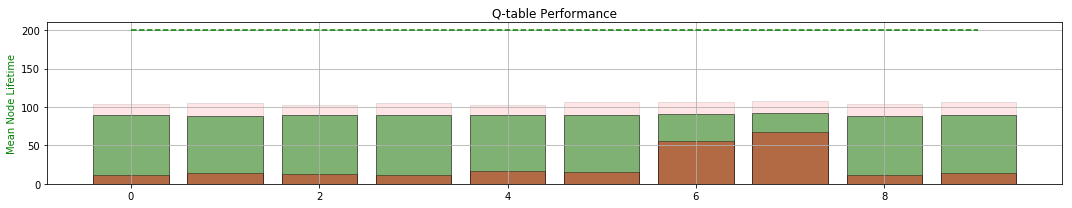

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 100.054	LOSS : 104.935	LOSS : 96.132	LOSS : 99.853	
Validating... MEAN TIME:  100.375
LOSS : 104.859	LOSS : 107.102	LOSS : 97.349	LOSS : 98.597	
Validating... MEAN TIME:  99.345
LOSS : 92.604	LOSS : 102.149	LOSS : 91.012	LOSS : 100.934	
Validating... MEAN TIME:  99.095
LOSS : 101.164	LOSS : 98.364	LOSS : 108.845	LOSS : 99.502	
Validating... MEAN TIME:  99.21
LOSS : 105.304	LOSS : 94.474	LOSS : 92.543	LOSS : 100.230	
Validating... MEAN TIME:  98.85
TRAINING TIME:0:00:42.990269


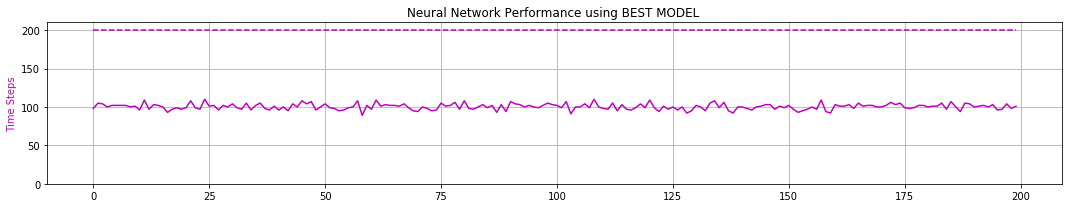

peak memory: 1462.12 MiB, increment: 1016.50 MiB
0 -max- [ 0.181  1.157  0.047  0.622]
0 -min- [-2.400 -3.300 -0.209 -1.744]

1 -max- [ 0.188  1.217  0.050  0.601]
1 -min- [-2.398 -3.295 -0.209 -1.664]

2 -max- [ 0.159  1.200  0.050  0.784]
2 -min- [-2.400 -3.256 -0.209 -1.676]

3 -max- [ 0.171  1.168  0.050  0.828]
3 -min- [-2.399 -3.289 -0.209 -1.677]

4 -max- [ 0.187  1.218  0.049  0.749]
4 -min- [-2.399 -3.290 -0.209 -1.696]

5 -max- [ 0.196  1.213  0.050  0.599]
5 -min- [-2.399 -3.312 -0.209 -1.669]

6 -max- [ 0.177  1.180  0.053  0.601]
6 -min- [-2.399 -3.316 -0.209 -1.660]

7 -max- [ 0.204  1.198  0.051  0.611]
7 -min- [-2.399 -3.297 -0.209 -1.664]

8 -max- [ 0.181  1.180  0.049  0.843]
8 -min- [-2.400 -3.297 -0.209 -1.870]

9 -max- [ 0.168  1.205  0.050  0.596]
9 -min- [-2.398 -3.319 -0.209 -1.684]

Quantization TIME:  0.02 minutes


ITERATION # 49
TOTAL EXPERIENCE GENERATED:   46375
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 84
TOTAL SERIAL TIMESTEPS:   3502617
TOTAL PARALLEL TI

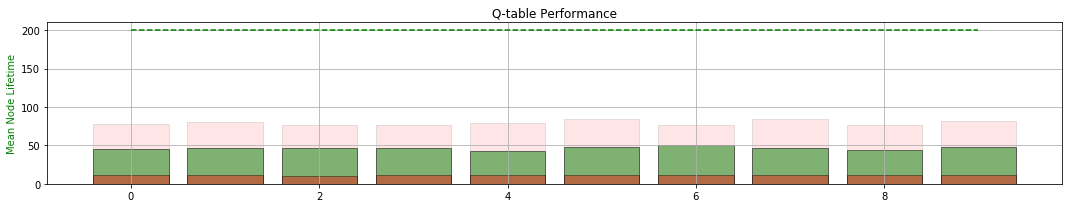

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 122.206	LOSS : 123.838	LOSS : 121.839	LOSS : 108.126	
Validating... MEAN TIME:  101.625
LOSS : 112.799	LOSS : 117.488	LOSS : 123.522	LOSS : 123.090	
Validating... MEAN TIME:  102.075
LOSS : 122.844	LOSS : 117.009	LOSS : 118.377	LOSS : 118.919	
Validating... MEAN TIME:  102.485
LOSS : 114.619	LOSS : 123.724	LOSS : 111.853	LOSS : 113.583	
Validating... MEAN TIME:  101.67
LOSS : 118.204	LOSS : 122.217	LOSS : 115.381	LOSS : 114.562	
Validating... MEAN TIME:  101.645
TRAINING TIME:0:00:42.812840


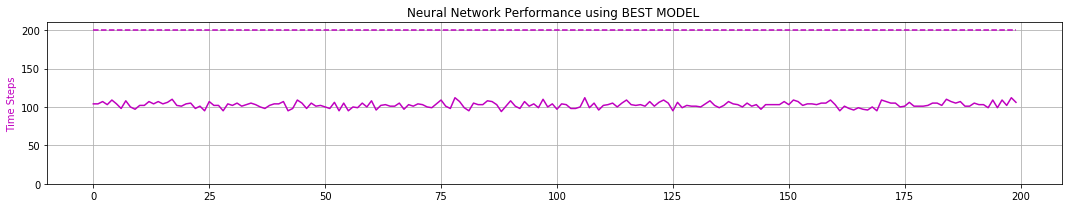

peak memory: 1419.48 MiB, increment: 1017.39 MiB
0 -max- [ 0.204  1.217  0.050  0.605]
0 -min- [-1.404 -2.565 -0.209 -1.745]

1 -max- [ 0.179  1.354  0.050  0.597]
1 -min- [-1.722 -2.768 -0.209 -1.953]

2 -max- [ 0.194  1.209  0.050  0.697]
2 -min- [-1.487 -2.607 -0.209 -1.707]

3 -max- [ 0.202  1.218  0.049  0.603]
3 -min- [-1.479 -2.604 -0.209 -1.691]

4 -max- [ 0.218  1.218  0.050  0.679]
4 -min- [-1.458 -2.581 -0.209 -1.679]

5 -max- [ 0.198  1.369  0.050  0.609]
5 -min- [-1.665 -2.754 -0.209 -1.962]

6 -max- [ 0.222  1.207  0.051  0.601]
6 -min- [-1.492 -2.600 -0.209 -1.664]

7 -max- [ 0.192  1.179  0.049  0.681]
7 -min- [-1.912 -2.888 -0.209 -1.756]

8 -max- [ 0.192  1.361  0.050  0.750]
8 -min- [-1.437 -2.555 -0.209 -1.956]

9 -max- [ 0.216  1.395  0.050  0.604]
9 -min- [-1.659 -2.772 -0.209 -1.969]

Quantization TIME:  0.02 minutes


In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5671.0
Total Serial Timesteps   :  3502617.0
Speed-up                 :  617.64


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 FAILURE  10  50    5671    3502617     617.64
